**Stores sale - Time Series Forecasting**  
Kaggle competition  
<https://www.kaggle.com/competitions/store-sales-time-series-forecasting/overview>

In [2]:
#!pip install pmdarima
#!pip install pystan==2.19.1.1
#!pip install prophet

     |████████████████████████████████| 1.4 MB 16.7 MB/s 
     |████████████████████████████████| 9.8 MB 26.9 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
     |████████████████████████████████| 65 kB 2.1 MB/s 
     |████████████████████████████████| 49 kB 7.0 MB/s 
     |████████████████████████████████| 45 kB 3.4 MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6640216 sha256=f349d90b368613f9b61d1f5de753ccd81e7d92d4cfca96cc63a40f9dd9b84c74
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages th

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
plt.rc('figure', figsize=(20, 10))
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from scipy.stats.stats import pearsonr

from datetime import datetime

In [4]:
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings("ignore")
import statsmodels.graphics.tsaplots as sgt
from scipy.stats.distributions import chi2
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from pmdarima.arima import auto_arima

from sklearn.metrics import r2_score, mean_squared_log_error,mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit,cross_val_score

import xgboost as xgb
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, space_eval
from hyperopt.pyll import scope

from prophet import Prophet

1. Load datasets

In [ ]:
%cd C:\Users\Dawid\Desktop\projekty\Store Time Series Forecasting

[Errno 2] No such file or directory: 'C:UsersDawidDesktopprojektyStore Time Series Forecasting'
/content


In [5]:
files = sorted(os.listdir('data'))

In [6]:
file_names = ['holidays','oil_prices','sample','stores','df_test','df_train','transactions']

In [7]:
# let read all files, although we won't use sample and df_test dataset
for i in range(len(files)):
    vars()[str(file_names[i])] = pd.read_csv('data/' + files[i])
    
    

**2. Preliminary data analysis**

- df_train


In [8]:
df = df_train
df
# The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.
# store_nbr identifies the store at which the products are sold.
# family identifies the type of product sold.
# sales gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
# onpromotion gives the total number of items in a product family that were being promoted at a store at a given date.

id        date  store_nbr                      family     sales  \
0              0  2013-01-01          1                  AUTOMOTIVE     0.000   
1              1  2013-01-01          1                   BABY CARE     0.000   
2              2  2013-01-01          1                      BEAUTY     0.000   
3              3  2013-01-01          1                   BEVERAGES     0.000   
4              4  2013-01-01          1                       BOOKS     0.000   
...          ...         ...        ...                         ...       ...   
3000883  3000883  2017-08-15          9                     POULTRY   438.133   
3000884  3000884  2017-08-15          9              PREPARED FOODS   154.553   
3000885  3000885  2017-08-15          9                     PRODUCE  2419.729   
3000886  3000886  2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   121.000   
3000887  3000887  2017-08-15          9                     SEAFOOD    16.000   

         onpromotion  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  
...              ...  
3000883            0  
3000884            1  
3000885          148  
3000886            8  
3000887            0  

[3000888 rows x 6 columns]

We would like focus on total sale, so let aggregate date and drop useless columns

In [9]:
df['date']= pd.to_datetime(df['date'])
df = df.groupby(['date'])['sales'].sum().to_frame()
df = df.asfreq('d').fillna(0)
df

sales
date                     
2013-01-01    2511.618999
2013-01-02  496092.417944
2013-01-03  361461.231124
2013-01-04  354459.677093
2013-01-05  477350.121229
...                   ...
2017-08-11  826373.722022
2017-08-12  792630.535079
2017-08-13  865639.677471
2017-08-14  760922.406081
2017-08-15  762661.935939

[1688 rows x 1 columns]

In our date set we have sales beetween 2013-01-01 to 2017-08-15

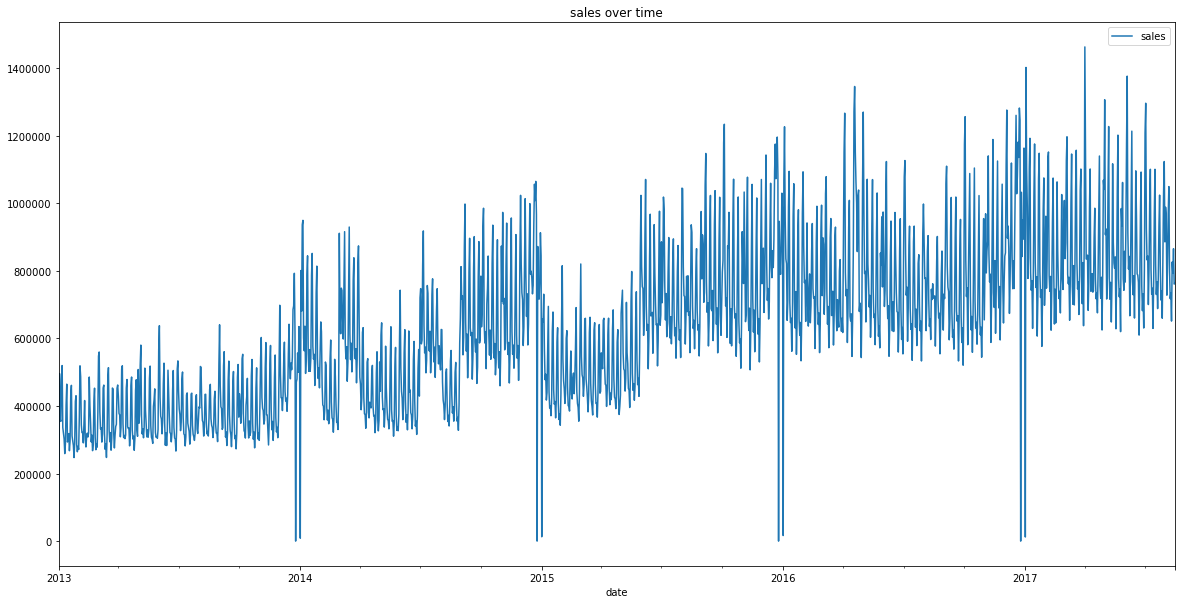

In [ ]:
df.plot()
plt.title('sales over time')
plt.ticklabel_format(axis = 'y', useOffset=False, style='plain')
plt.show()

How we can see in sales we have clear trend over those years, and seasional trend near the end of the year

- stores

In [ ]:
# we have list of stores, which sale we will predict.
stores.sample(10)

store_nbr       city       state type  cluster
34         35     Playas      Guayas    C        3
31         32  Guayaquil      Guayas    C        3
13         14   Riobamba  Chimborazo    C        7
36         37     Cuenca       Azuay    D        2
27         28  Guayaquil      Guayas    E       10
52         53      Manta      Manabi    D       13
37         38       Loja        Loja    D        4
2           3      Quito   Pichincha    D        8
33         34  Guayaquil      Guayas    B        6
44         45      Quito   Pichincha    A       11

In [ ]:
# we have 54 different stores
print('number of stores =', stores['store_nbr'].unique().size)

number of stores = 54


In [ ]:
# stores are clustered on 17 clusters
print('clusters_number = ', stores['cluster'].value_counts().size)

clusters_number =  17


In [ ]:
# stores are distinguished by 5 types
print('types_number = ', stores['type'].value_counts().size)

types_number =  5


- oil prices

In [ ]:
# Ecuador market is oil prices dependent so we should take them into consideration
oil_prices.sample(10)

In [10]:
# let set date as index and fill NaN for empty dates
oil_prices['date'] = pd.to_datetime(oil_prices['date'])
oil_prices = oil_prices.set_index('date').asfreq('d')
oil_prices.fillna(method = 'bfill', inplace = True)
oil_prices.rename(columns = {'dcoilwtico': 'oil_price'}, inplace= True)
oil_prices

oil_price
date                 
2013-01-01      93.14
2013-01-02      93.14
2013-01-03      92.97
2013-01-04      93.12
2013-01-05      93.20
...               ...
2017-08-27      46.40
2017-08-28      46.40
2017-08-29      46.46
2017-08-30      45.96
2017-08-31      47.26

[1704 rows x 1 columns]

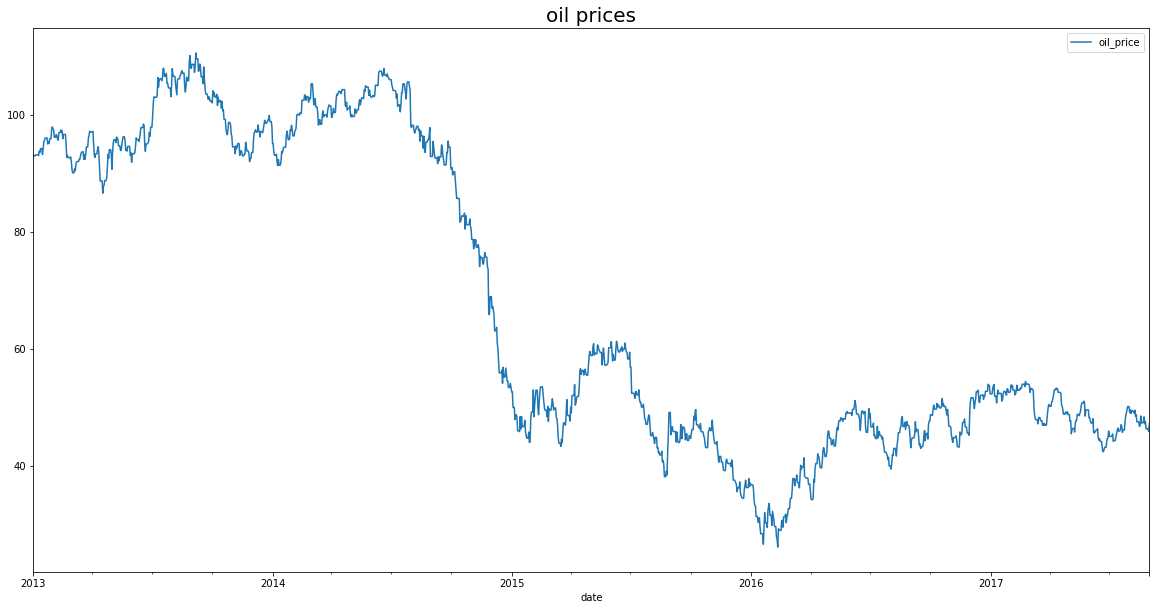

In [ ]:
# oil prices over time
oil_prices.plot(figsize = (20,10))
plt.title ('oil prices', size = 20)
plt.show()

<AxesSubplot:xlabel='date'>

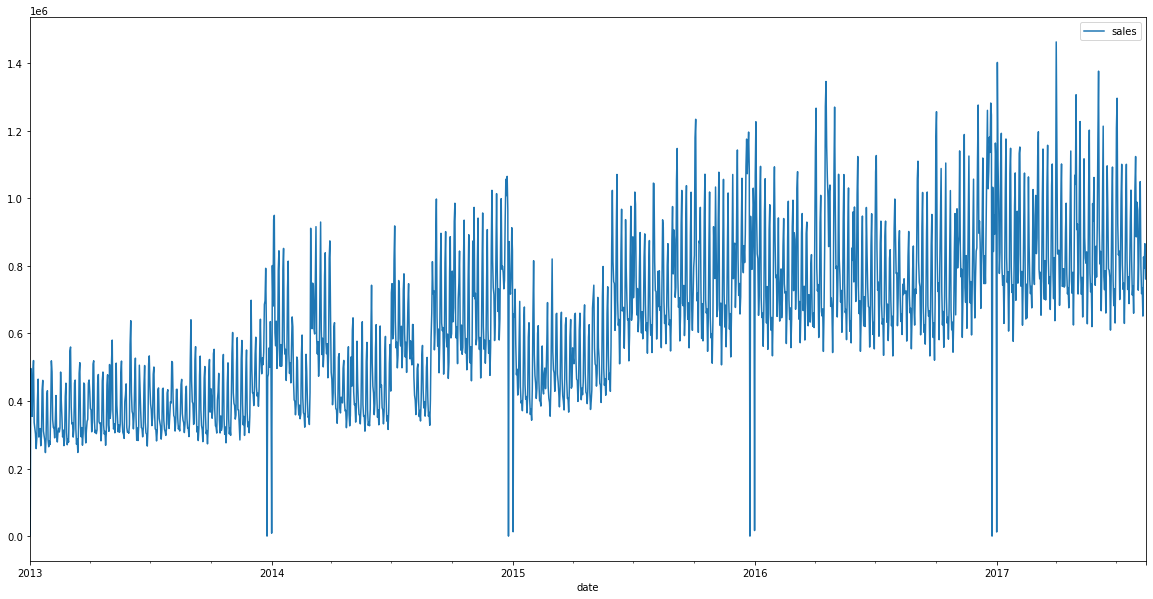

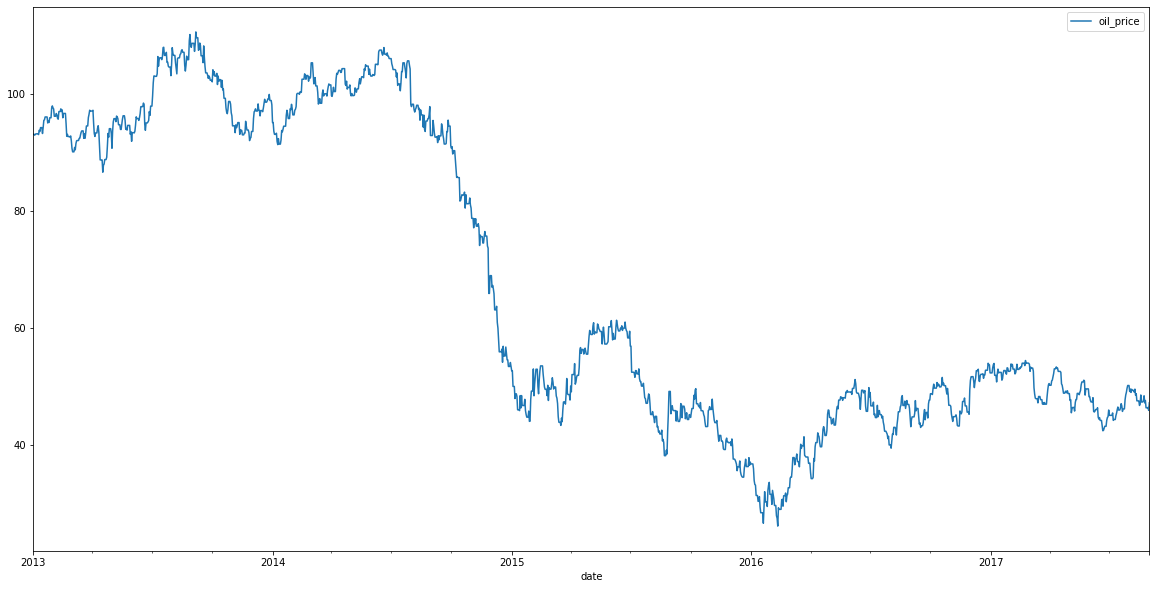

In [ ]:
# let's have a look if there is any relation beetween oil prices and sale
df.plot()
oil_prices.plot()

It is difficult to say if there is any relation, based on charts.  
Let's try examine relation between them using correlation function.
We check whether the two variables change in the same direction (positive) or change in different directions (negative), by using covarinace
A covariance value of zero indicates that both variables are completely independent.

In [ ]:
pearsonr(df['sales'], oil_prices['oil_price'][:len(df)])

(-0.6209175996570805, 1.5700650185277765e-180)

How we can see between those two variables exist, quite strong negative correlation -0.62, with strong significance (p_value) almost 0.

In [ ]:
covariance = np.cov(df['sales'], oil_prices['oil_price'][:len(df)])
covariance

array([[ 5.57793817e+10, -3.77009144e+06],
       [-3.77009144e+06,  6.60940145e+02]])

How we can see covariance rate between those two variables are near to zero, what mean that they completely independent.  
It is what we expected.

So we can assume that oil price can affect our sale and we should take it into consideration.

- transactions

In [ ]:
# transactions dataset cointain all transactions by store over time, representing as number of transactions
transactions

date  store_nbr  transactions
0      2013-01-01         25           770
1      2013-01-02          1          2111
2      2013-01-02          2          2358
3      2013-01-02          3          3487
4      2013-01-02          4          1922
...           ...        ...           ...
83483  2017-08-15         50          2804
83484  2017-08-15         51          1573
83485  2017-08-15         52          2255
83486  2017-08-15         53           932
83487  2017-08-15         54           802

[83488 rows x 3 columns]

In [11]:
#let aggregate transactions per day
transactions['date'] = pd.to_datetime(transactions['date'])
transactions_agg = transactions.groupby(['date'])['transactions'].sum().to_frame()
trans_agg = transactions_agg.asfreq('d').fillna(0)

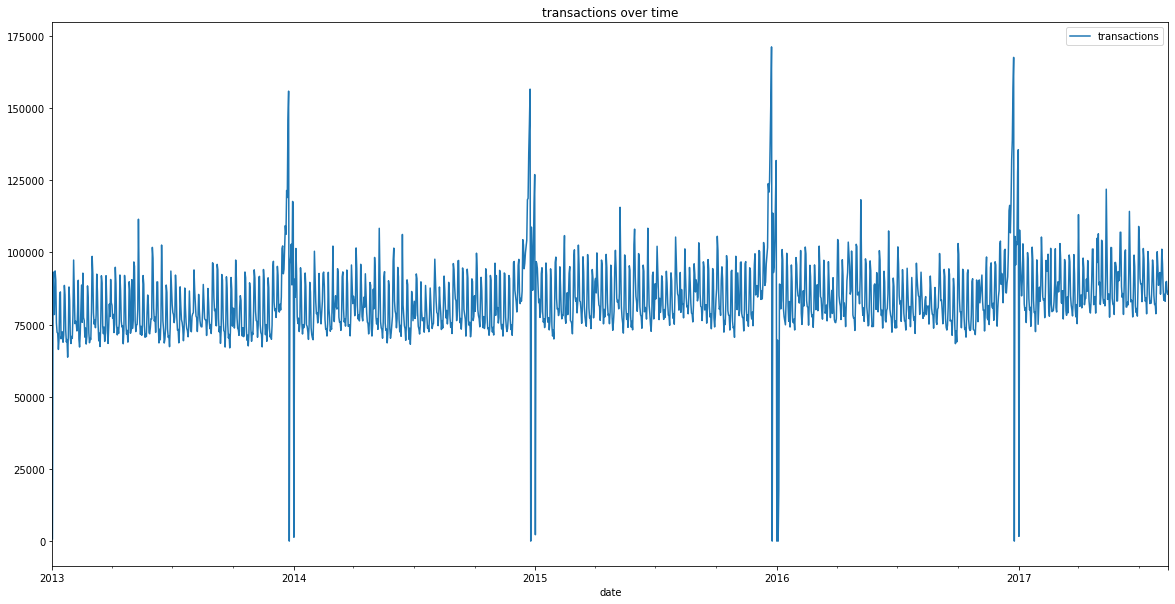

In [ ]:
trans_agg.plot()
plt.title('transactions over time')
plt.show()

How we can see number of transactions doesn't have clear trend.  
We can see only seasonal trend at the turn of each year, what is typicall during the Christmas period in retail.

- holidays

In [ ]:
# list of local holidays
holidays.sample(10)

date     type    locale  locale_name  \
160  2015-01-02   Bridge  National      Ecuador   
128  2014-07-25  Holiday     Local    Guayaquil   
288  2016-12-08  Holiday     Local         Loja   
6    2012-06-23  Holiday     Local     Guaranda   
1    2012-04-01  Holiday  Regional     Cotopaxi   
194  2015-11-07  Holiday  Regional  Santa Elena   
311  2017-05-14    Event  National      Ecuador   
344  2017-12-22  Holiday     Local      Salinas   
275  2016-11-02  Holiday  National      Ecuador   
5    2012-05-12  Holiday     Local         Puyo   

                       description  transferred  
160      Puente Primer dia del ano        False  
128         Fundacion de Guayaquil        False  
288              Fundacion de Loja        False  
6        Cantonizacion de Guaranda        False  
1    Provincializacion de Cotopaxi        False  
194  Provincializacion Santa Elena        False  
311                Dia de la Madre        False  
344       Cantonizacion de Salinas        False  
275                Dia de Difuntos        False  
5           Cantonizacion del Puyo        False

In [12]:
#let use only date as an index and add new column [0,1,2,3,4,5] indicate type of holiday, and -1 mean that there wasn't any holidays
holidays['date'] = pd.to_datetime(holidays['date'])
holidays1 = holidays.iloc[:,:2].set_index('date')

le = LabelEncoder()
y = le.fit_transform(holidays1['type'])
holidays1['type'] = y


#delete duplicates, when 
holidays2 = holidays1.groupby(holidays1.index).first()

holidays_list = holidays2.asfreq('d')
holidays_list.fillna(-1, inplace = True)

In [ ]:
print("types description", '\n',
      list(le.classes_), '\n',
      list(le.transform(list(le.classes_))))

types description 
 ['Additional', 'Bridge', 'Event', 'Holiday', 'Transfer', 'Work Day'] 
 [0, 1, 2, 3, 4, 5]


In [ ]:
# we have 312 days off in range beetwen 2012-03-02 to 2017-12-26
holidays_list['type'].value_counts()

-1.0    1814
 3.0     199
 2.0      49
 0.0      45
 4.0      10
 1.0       5
 5.0       4
Name: type, dtype: int64

We can see that mostly we have holiday type 'Holiday' 199 times, then 49 times 'Event' , 45 times 'Additional' etc

**3. Data concatenate**

In [13]:
# let join all probably usefull data
dataset = pd.concat([holidays_list,df,trans_agg, oil_prices ] , axis =1)
dataset.dropna(inplace = True)

**4. Features engineering**

In [14]:
#Let's add some features to our dateset

#day week (1 - Monday, 7 Sunday)
dataset['wday'] = [datetime.weekday(i)+1 for i in dataset.index]

**5. Train/test split**

In [15]:
# let split data set into test and train
treshold = int(len(dataset)*0.8)

train = dataset.iloc[:treshold,:]
test  = dataset.iloc[treshold:,:]

In [ ]:
print('train size lenght is: ', len(train), '\n'
     'test_size lenght is: ', len(test))

train size lenght is:  1350 
test_size lenght is:  338


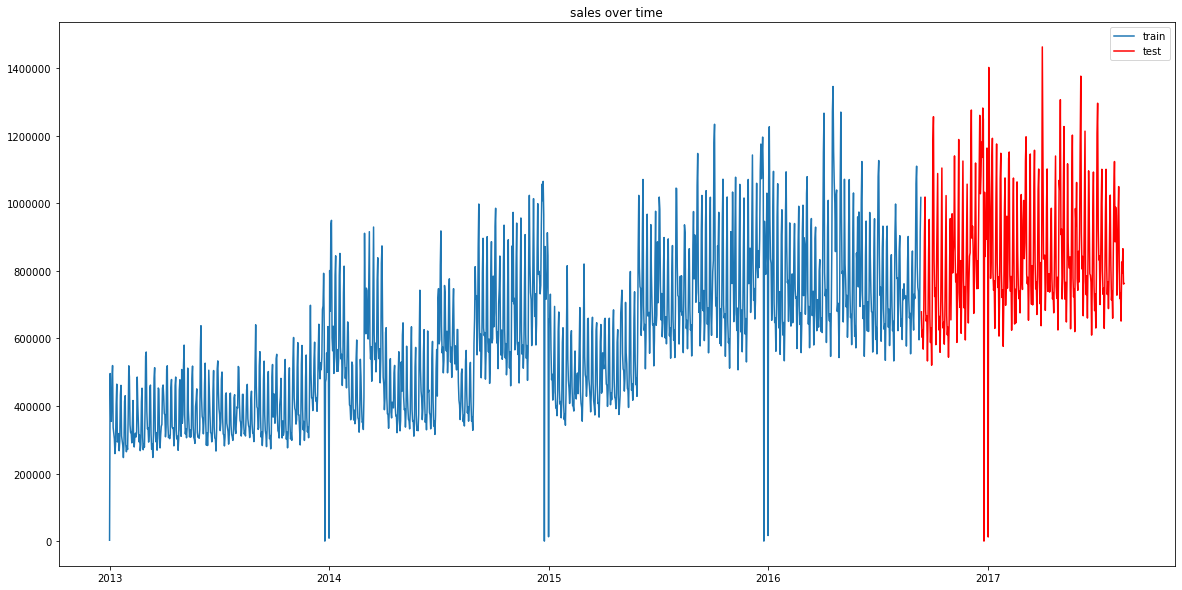

In [ ]:
#plot train and test sale 

plt.plot(train.index, train['sales'], label = 'train')
plt.plot(test.index, test['sales'],color = 'red', label = 'test')
plt.title('sales over time')
plt.ticklabel_format(axis = 'y', useOffset=False, style='plain')
plt.legend()
plt.show()

In [16]:
#let's determine future holidays in case of forecast need till the end of 2017 year
holidays_future = holidays_list.loc[holidays_list.index > pd.to_datetime('2017-08-15')]
holidays_future[holidays_future.type >= 0].head()

type
date            
2017-08-24   3.0
2017-09-28   3.0
2017-09-29   4.0
2017-10-07   3.0
2017-10-09   3.0

**6. Stationary test**

In [ ]:
# Let check whether our data is stationary or not

# ADF test for 'sale' variable
result_adf = sts.adfuller(train['sales'])
print('p_value = ', result_adf[1])

p_value =  0.10530064305089226


P value > 0.05 mean that our data isn't stationarity.  
In some models we will need to make them stationarity, so let's implement some solutions to gain it

- transforming data to percentage change format, called 'return'

In [17]:
train['sales_ret']= train['sales'].pct_change(1)*100
train['sales_ret']

date
2013-01-01             NaN
2013-01-02    19651.897805
2013-01-03      -27.138328
2013-01-04       -1.937014
2013-01-05       34.669795
                  ...     
2016-09-07       -1.734886
2016-09-08      -19.321074
2016-09-09       10.593237
2016-09-10       38.995692
2016-09-11       11.073960
Freq: D, Name: sales_ret, Length: 1350, dtype: float64

In [18]:
# and let's check again whether data is still stationary or not
# ADF test for 'sales_ret' variable

#first we have to delete or replace inf values
train['sales_ret'] = [1000 if j == np.inf else train['sales_ret'][i] for i,j in enumerate(train['sales_ret'])]

result_adf_1 = sts.adfuller(train['sales_ret'][1:])
print('p_value = ', result_adf_1[1])

p_value =  1.2480915313707755e-26


This way let us to gain stationarity in our data, but let try another method too.

- first order differencing

In [19]:
train['sales_diff'] = train['sales'].diff(1)

In [ ]:
# ADF test for 'sales_diff' variable

result_adf_2 = sts.adfuller(train['sales_diff'][1:])
print('p_value = ', result_adf_2[1])

p_value =  4.072269153214223e-14


Thanks to the first order differencing our data is totally stationary

In [20]:
#let create return and 1st order differencing data also for our test dataset
test1 = pd.concat([train.iloc[-1:,:5],test])
test1['sales_ret'] =  test1['sales'].pct_change(1)*100
test1['sales_diff'] =   test1['sales'].diff(1)
test = test1.iloc[1:]

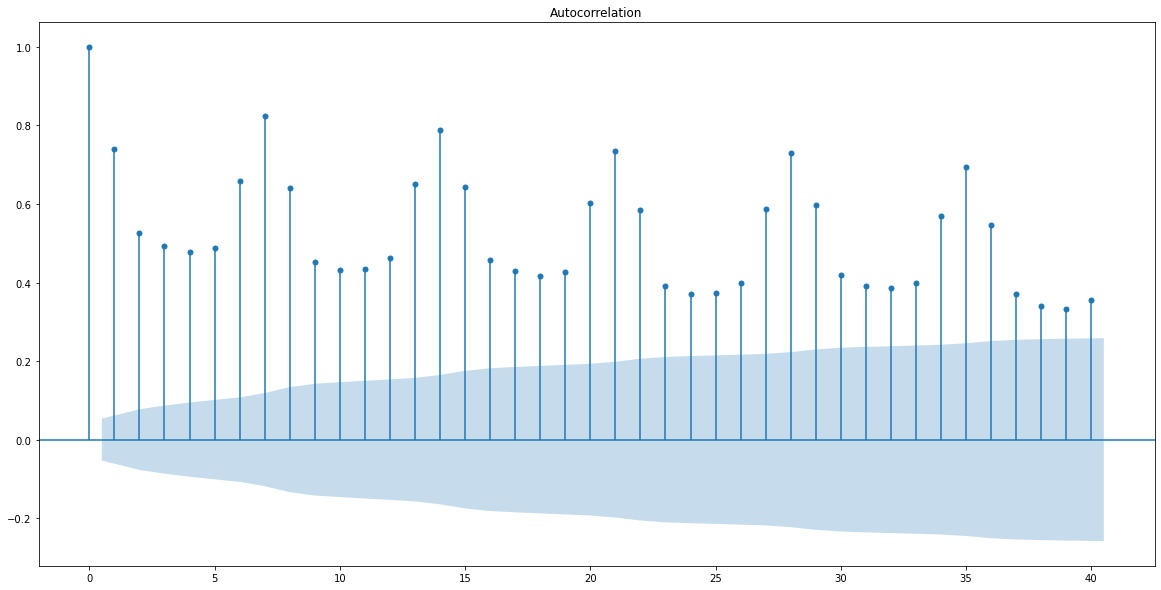

In [ ]:
# Let check if our data isn't white noise or random walk 
sgt.plot_acf(train['sales'], lags = 40)
plt.show()

As we can see all data (till 40 lag) is significant, so we can't consider this data set as a white noise.

*Random walk testing*  
As we know, our data isn't stationary so it can be consider as a random walk,  
so we need to see how look autocorrelation for first-order diffence data

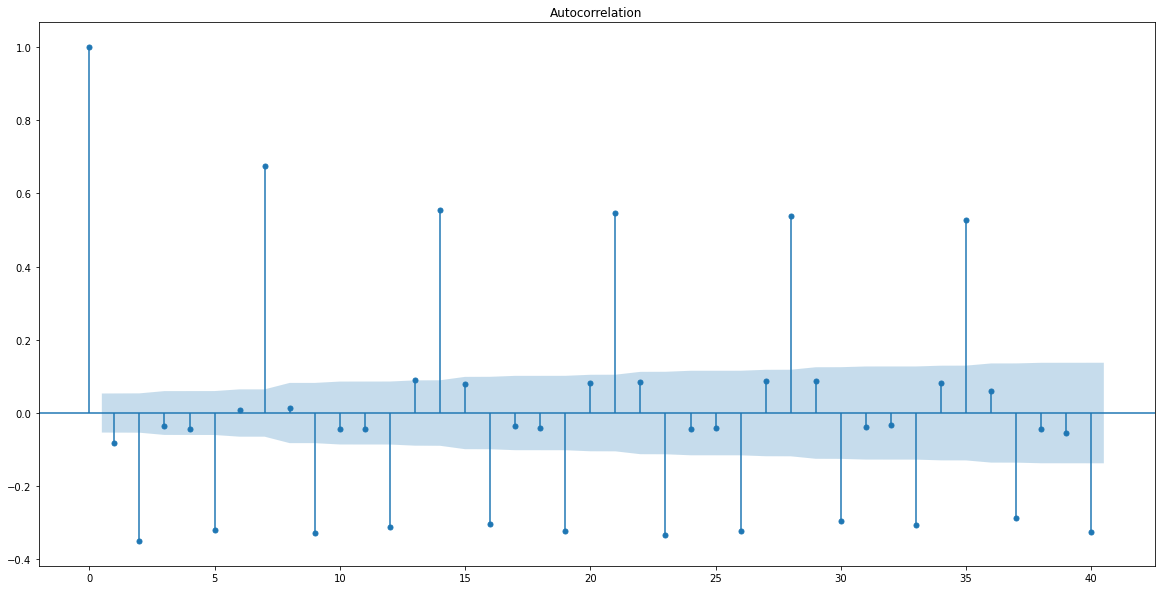

In [ ]:
sgt.plot_acf(train['sales_diff'][1:],lags =40)
plt.show()

Even first-order differenced data isn't random noise, so we can't talk about random walk in our data.  
It is good information, because we can expect that are data are able to be predict.

In this data we can see that every 7th lag is significant, it tells us about weakly seasonal effects 

To have full view on our data let's check also partial autocorrelation function

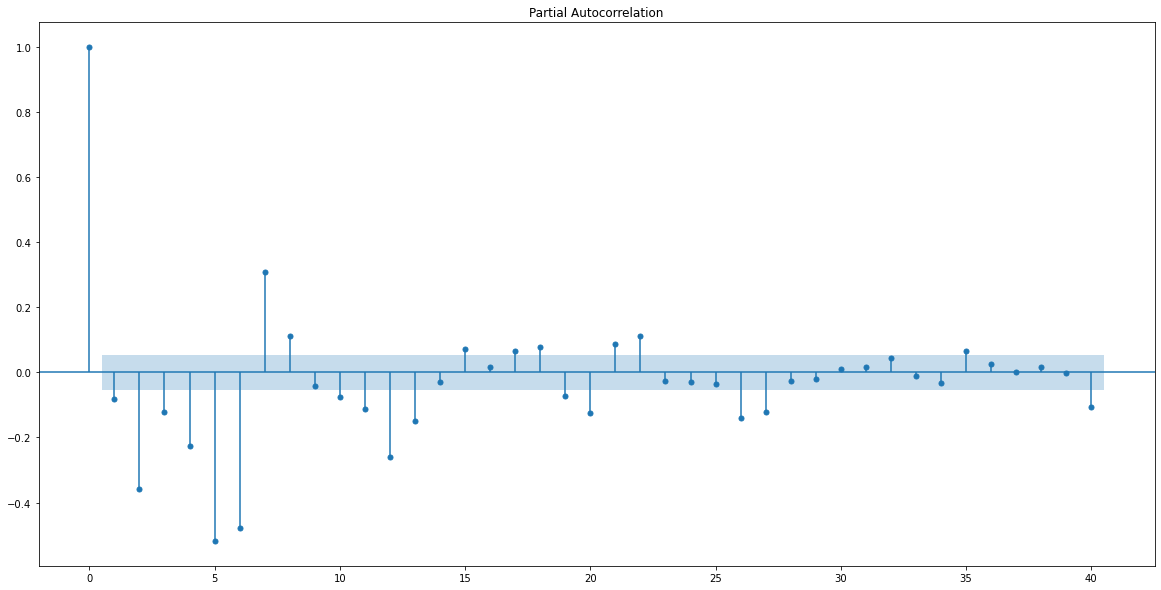

In [ ]:
sgt.plot_pacf(train['sales_diff'][1:], lags = 40, method = 'ols')
plt.show()

According to the results from previous pacf_plot it seems than at least 8 periods before, but also 13 or even 22lags can be use to predict future sale.
We also check 7 periods, because it is common trend in retail.

**7. Trend decomposition**

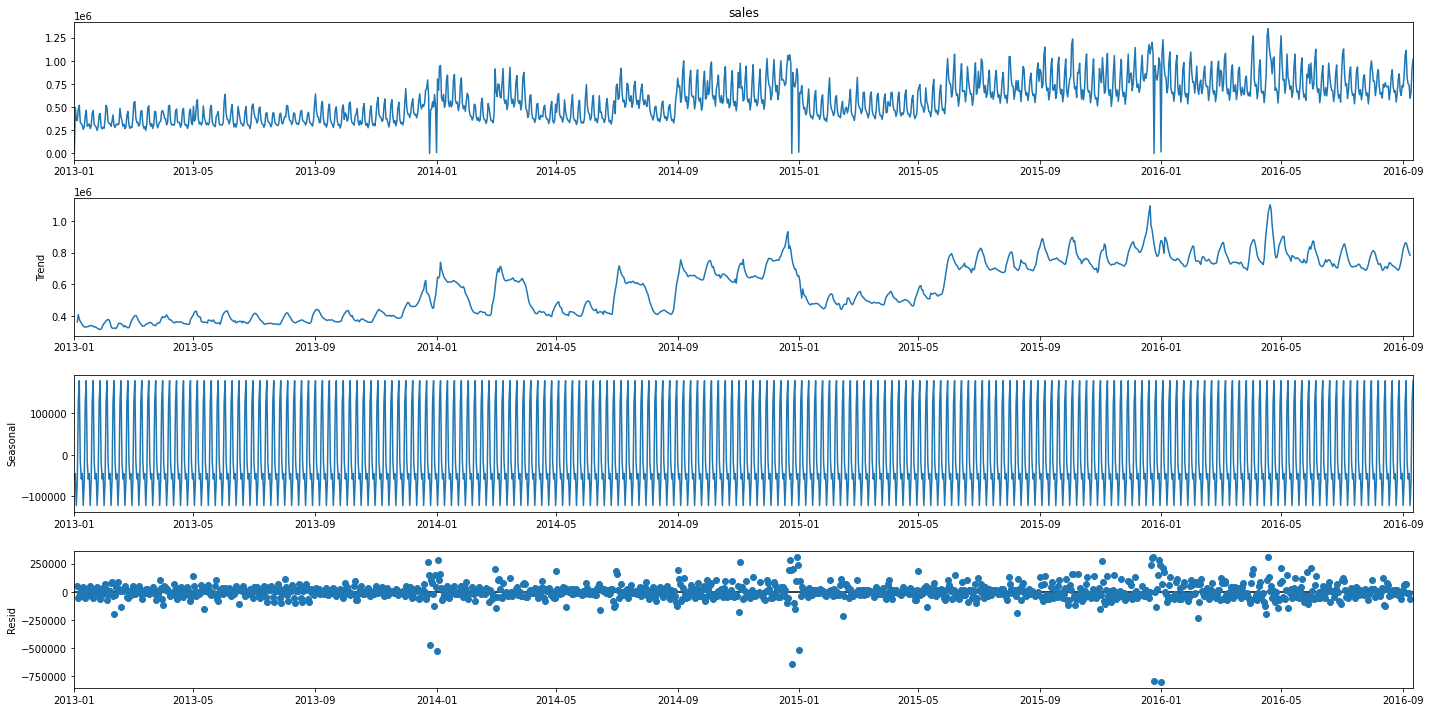

In [ ]:
#Let furthermore check trend composition to know what cycles we can noticed

decomp = seasonal_decompose(train['sales'])
decomp.plot()
plt.show()

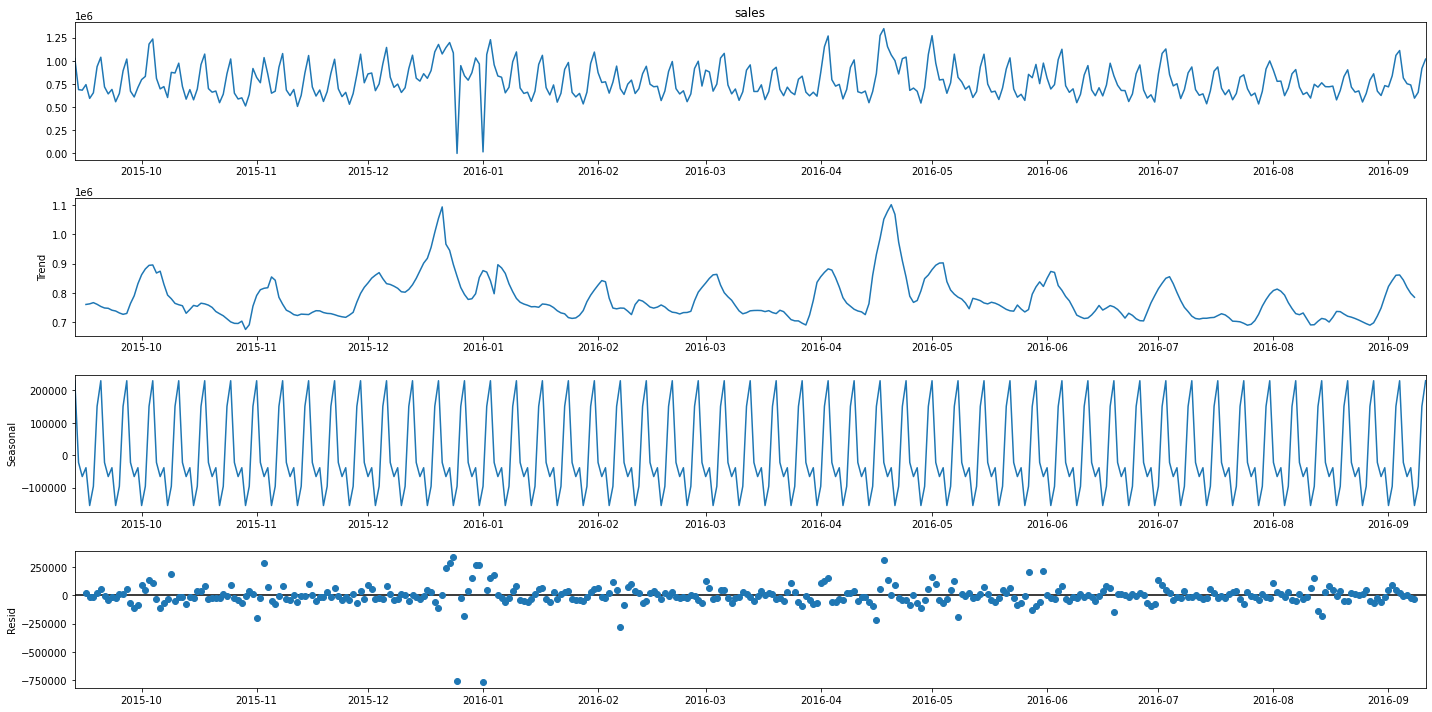

In [ ]:
#only last 12 months
decomp_year = seasonal_decompose(train['sales'][-365:])
decomp_year.plot()
plt.show()

How we can see there is a significant seasonal component in our data, and seasonality pick is four times per month.
Our residuals errors are close to zero, but at the year turn appear to be bigger than usually.

**8. Modeling**

- ARMA

Let's create some simple models to get a banchmark for future improvments.  
First we will rank models by their Log Likelihood ratio.

In [ ]:
#let's create a test to compare simple models
def LLR_test(model1, model2, DF = 1):
    L1 = model1.llf
    L2 = model2.llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR,DF).round(3)
    return p

In [ ]:
# simple ARMA models
model_arma_7_0 = ARMA(train['sales_diff'][1:], order = (7,0)).fit()
model_arma_7_0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             sales_diff   No. Observations:                 1349
Model:                     ARMA(7, 0)   Log Likelihood              -17436.943
Method:                       css-mle   S.D. of innovations          99235.384
Date:                Sun, 10 Apr 2022   AIC                          34891.886
Time:                        14:17:25   BIC                          34938.750
Sample:                    01-02-2013   HQIC                         34909.437
                         - 09-11-2016                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              752.3036    859.023      0.876      0.381    -931.350    2435.957
ar.L1.sales_diff    -0.4040      0.026    -15.522      0.000      -0.455      -0.353
ar.L2.sales_diff    -0.4926      0.027    -18.266      0.000      -0.545      -0.440
ar.L3.sales_diff    -0.4088      0.028    -14.833      0.000      -0.463      -0.355
ar.L4.sales_diff    -0.4000      0.028    -14.480      0.000      -0.454      -0.346
ar.L5.sales_diff    -0.4502      0.028    -16.360      0.000      -0.504      -0.396
ar.L6.sales_diff    -0.3091      0.027    -11.457      0.000      -0.362      -0.256
ar.L7.sales_diff     0.3107      0.026     11.929      0.000       0.260       0.362
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0051           -0.4809j            1.1142           -0.4290
AR.2           -1.0051           +0.4809j            1.1142            0.4290
AR.3           -0.2401           -1.0168j            1.0447           -0.2869
AR.4           -0.2401           +1.0168j            1.0447            0.2869
AR.5            0.6516           -0.8149j            1.0434           -0.1427
AR.6            0.6516           +0.8149j            1.0434            0.1427
AR.7            2.1820           -0.0000j            2.1820           -0.0000
-----------------------------------------------------------------------------
"""

In [ ]:
model_arma_7_1 = ARMA(train['sales_diff'][1:], order = (7,1)).fit()
model_arma_7_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             sales_diff   No. Observations:                 1349
Model:                     ARMA(7, 1)   Log Likelihood              -17431.254
Method:                       css-mle   S.D. of innovations          98815.340
Date:                Sun, 10 Apr 2022   AIC                          34882.507
Time:                        14:17:57   BIC                          34934.578
Sample:                    01-02-2013   HQIC                         34902.008
                         - 09-11-2016                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              752.3035    943.304      0.798      0.425   -1096.537    2601.145
ar.L1.sales_diff    -0.2054      0.056     -3.658      0.000      -0.315      -0.095
ar.L2.sales_diff    -0.3806      0.036    -10.455      0.000      -0.452      -0.309
ar.L3.sales_diff    -0.2686      0.043     -6.278      0.000      -0.352      -0.185
ar.L4.sales_diff    -0.2811      0.038     -7.338      0.000      -0.356      -0.206
ar.L5.sales_diff    -0.3320      0.038     -8.780      0.000      -0.406      -0.258
ar.L6.sales_diff    -0.1752      0.041     -4.247      0.000      -0.256      -0.094
ar.L7.sales_diff     0.4102      0.033     12.490      0.000       0.346       0.475
ma.L1.sales_diff    -0.2193      0.058     -3.767      0.000      -0.333      -0.105
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0153           -0.4940j            1.1291           -0.4279
AR.2           -1.0153           +0.4940j            1.1291            0.4279
AR.3           -0.2340           -1.0178j            1.0443           -0.2860
AR.4           -0.2340           +1.0178j            1.0443            0.2860
AR.5            0.6465           -0.8099j            1.0362           -0.1428
AR.6            0.6465           +0.8099j            1.0362            0.1428
AR.7            1.6328           -0.0000j            1.6328           -0.0000
MA.1            4.5593           +0.0000j            4.5593            0.0000
-----------------------------------------------------------------------------
"""

In [ ]:
#let create a function that provide us model name and his results, we will use it then in the loop
AR_comp = [7,8,12,15,22]
MA_comp = [1,2,3,5,7]

def model_arma(x,AR_comp, MA_comp,name = 'name'):
    model = ARMA(x, order =(AR_comp, MA_comp))
    result = model.fit()
    return {name: round(result.llf,3)}

In [ ]:
#let check a few diffent models, which will gain the best results, according to the Log Likelihood
loop_results = dict()

for ar in AR_comp:
    for ma in MA_comp:
        try:
            x = model_arma(train['sales_diff'][1:], ar, ma, name = 'model_arma_' + str(ar) + '_' + str(ma))
            loop_results.update(x)
            print('model_arma_' + str(ar) +"_" + str(ma))
        except:
            continue

model_arma_7_1
model_arma_7_2
model_arma_7_3
model_arma_7_5
model_arma_7_7
model_arma_8_1
model_arma_8_2
model_arma_8_3
model_arma_8_5
model_arma_8_7
model_arma_12_1
model_arma_12_2
model_arma_12_7
model_arma_15_1
model_arma_15_3
model_arma_15_5
model_arma_22_1
model_arma_22_2


{'model_arma_7_1': -17431.254,
 'model_arma_7_2': -17426.675,
 'model_arma_7_3': -17425.074,
 'model_arma_7_5': -17364.03,
 'model_arma_7_7': -17302.503,
 'model_arma_8_1': -17427.929,
 'model_arma_8_2': -17365.794,
 'model_arma_8_3': -17360.303,
 'model_arma_8_5': -17339.854,
 'model_arma_8_7': -17301.937,
 'model_arma_12_1': -17354.974,
 'model_arma_12_2': -17331.438,
 'model_arma_12_7': -17288.971,
 'model_arma_15_1': -17346.41,
 'model_arma_15_3': -17342.224,
 'model_arma_15_5': -17313.742,
 'model_arma_22_1': -17313.038,
 'model_arma_22_2': -17312.784}

In [ ]:
#Let check 5 best models
best_arma = pd.DataFrame([loop_results]).T.rename(columns = {0: 'result'})
best_arma.sort_values(by = 'result', ascending = False).head(5)

result
model_arma_12_7 -17288.971
model_arma_8_7  -17301.937
model_arma_7_7  -17302.503
model_arma_22_2 -17312.784
model_arma_22_1 -17313.038

How we can see best models has mostly 7 MA lags, and the more AR lags the better, but not too many, because models don't perform much better and their computation last very long.  
But let's check if all coefitents are significant

In [ ]:
model_arma_12_7 = ARMA(train['sales_diff'][1:], order = (12,7))
results_arma_12_7 = model_arma_12_7.fit()
results_arma_12_7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             sales_diff   No. Observations:                 1349
Model:                    ARMA(12, 7)   Log Likelihood              -17288.971
Method:                       css-mle   S.D. of innovations          88126.409
Date:                Sun, 10 Apr 2022   AIC                          34619.941
Time:                        19:37:15   BIC                          34729.291
Sample:                    01-02-2013   HQIC                         34660.894
                         - 09-11-2016                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               752.2965      0.135   5566.468      0.000     752.032     752.561
ar.L1.sales_diff     -0.3440        nan        nan        nan         nan         nan
ar.L2.sales_diff     -0.3651   1.82e-05  -2.01e+04      0.000      -0.365      -0.365
ar.L3.sales_diff     -0.5155   2.87e-05  -1.79e+04      0.000      -0.516      -0.515
ar.L4.sales_diff     -0.0022   2.53e-05    -86.345      0.000      -0.002      -0.002
ar.L5.sales_diff     -0.6492        nan        nan        nan         nan         nan
ar.L6.sales_diff     -0.0427   1.31e-06  -3.27e+04      0.000      -0.043      -0.043
ar.L7.sales_diff      0.5653        nan        nan        nan         nan         nan
ar.L8.sales_diff      0.1495   7.33e-05   2040.267      0.000       0.149       0.150
ar.L9.sales_diff      0.1303   6.11e-06   2.13e+04      0.000       0.130       0.130
ar.L10.sales_diff     0.1137   5.72e-05   1987.744      0.000       0.114       0.114
ar.L11.sales_diff    -0.0583   5.15e-05  -1133.929      0.000      -0.058      -0.058
ar.L12.sales_diff     0.1400        nan        nan        nan         nan         nan
ma.L1.sales_diff     -0.1940      0.023     -8.258      0.000      -0.240      -0.148
ma.L2.sales_diff      0.0149      0.021      0.720      0.472      -0.026       0.055
ma.L3.sales_diff      0.2598      0.019     13.618      0.000       0.222       0.297
ma.L4.sales_diff     -0.3894      0.014    -28.733      0.000      -0.416      -0.363
ma.L5.sales_diff      0.5227      0.016     32.572      0.000       0.491       0.554
ma.L6.sales_diff     -0.4565      0.022    -20.686      0.000      -0.500      -0.413
ma.L7.sales_diff     -0.5260      0.026    -20.520      0.000      -0.576      -0.476
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -1.0329           -0.0000j            1.0329           -0.5000
AR.2            -1.0580           -0.4585j            1.1531           -0.4349
AR.3            -1.0580           +0.4585j            1.1531            0.4349
AR.4            -0.2226           -0.9749j            1.0000           -0.2857
AR.5            -0.2226           +0.9749j            1.0000            0.2857
AR.6            -0.2876           -1.3143j            1.3454           -0.2843
AR.7            -0.2876           +1.3143j            1.3454            0.2843
AR.8             0.6236           -0.7818j            1.0000           -0.1428
AR.9             0.6236           +0.7818j            1.0000            0.1428
AR.10            1.1879           -0.0000j            1.1879           -0.0000
AR.11            1.0753           -1.1232j            1.5550           -0.1285
AR.12            1.0753           +1.1232j            1.5550            0.1285

In this model we got some Nan's in summary, it can mean that our model isn't right for our predictions, and there is a problem with model converge

In [ ]:
model_arma_8_7 = ARMA(train['sales_diff'][1:], order = (8,7))
results_arma_8_7 = model_arma_8_7.fit()
results_arma_8_7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             sales_diff   No. Observations:                 1349
Model:                     ARMA(8, 7)   Log Likelihood              -17301.976
Method:                       css-mle   S.D. of innovations          89549.261
Date:                Sun, 24 Apr 2022   AIC                          34637.952
Time:                        20:10:26   BIC                          34726.473
Sample:                    01-02-2013   HQIC                         34671.104
                         - 09-11-2016                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              752.2938    448.345      1.678      0.093    -126.446    1631.034
ar.L1.sales_diff    -0.3960      0.078     -5.048      0.000      -0.550      -0.242
ar.L2.sales_diff    -0.4730      0.047    -10.149      0.000      -0.564      -0.382
ar.L3.sales_diff    -0.5467      0.059     -9.294      0.000      -0.662      -0.431
ar.L4.sales_diff    -0.3164      0.056     -5.626      0.000      -0.427      -0.206
ar.L5.sales_diff    -0.6592      0.045    -14.551      0.000      -0.748      -0.570
ar.L6.sales_diff    -0.2696      0.066     -4.108      0.000      -0.398      -0.141
ar.L7.sales_diff     0.3704      0.040      9.341      0.000       0.293       0.448
ar.L8.sales_diff     0.0228      0.034      0.670      0.503      -0.044       0.089
ma.L1.sales_diff    -0.1485      0.077     -1.921      0.055      -0.300       0.003
ma.L2.sales_diff     0.1076      0.068      1.571      0.116      -0.027       0.242
ma.L3.sales_diff     0.2126      0.060      3.572      0.000       0.096       0.329
ma.L4.sales_diff    -0.1718      0.059     -2.934      0.003      -0.287      -0.057
ma.L5.sales_diff     0.3948      0.053      7.421      0.000       0.291       0.499
ma.L6.sales_diff    -0.2896      0.058     -4.963      0.000      -0.404      -0.175
ma.L7.sales_diff    -0.5338      0.063     -8.531      0.000      -0.656      -0.411
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.6237           -0.7818j            1.0001           -0.1428
AR.2            0.6237           +0.7818j            1.0001            0.1428
AR.3           -0.2230           -0.9758j            1.0010           -0.2858
AR.4           -0.2230           +0.9758j            1.0010            0.2858
AR.5           -1.0849           -0.3757j            1.1481           -0.4469
AR.6           -1.0849           +0.3757j            1.1481            0.4469
AR.7            1.9712           -0.0000j            1.9712           -0.0000
AR.8          -16.8672           -0.0000j           16.8672           -0.5000
MA.1            1.1118           -0.0000j            1.1118           -0.0000
MA.2            0.6288           -0.7879j            1.0081           -0.1428
MA.3            0.6288           +0.7879j            1.0081            0.1428
MA.4           -0.2272           -0.9987j            1.0242           -0.2856
MA.5           -0.2272           +0.9987j            1.0242            0.2856
MA.6           -1.2288           -0.2648j            1.2571           -0.4662
MA.7           -1.2288           +0.2648j            1.2571            0.4662
-----------------------------------------------------------------------------
"""

In this model last AR coeficient isn't significant, so let try model ARMA(7,7)

In [ ]:
model_arma_7_7 = ARMA(train['sales_diff'][1:], order = (7,7))
results_arma_7_7 = model_arma_7_7.fit()
results_arma_7_7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             sales_diff   No. Observations:                 1349
Model:                     ARMA(7, 7)   Log Likelihood              -17302.207
Method:                       css-mle   S.D. of innovations          89586.373
Date:                Sun, 24 Apr 2022   AIC                          34636.415
Time:                        20:07:57   BIC                          34719.728
Sample:                    01-02-2013   HQIC                         34667.617
                         - 09-11-2016                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              752.2461    453.985      1.657      0.098    -137.548    1642.040
ar.L1.sales_diff    -0.3600      0.087     -4.152      0.000      -0.530      -0.190
ar.L2.sales_diff    -0.4903      0.045    -10.824      0.000      -0.579      -0.402
ar.L3.sales_diff    -0.5333      0.074     -7.202      0.000      -0.678      -0.388
ar.L4.sales_diff    -0.3290      0.060     -5.451      0.000      -0.447      -0.211
ar.L5.sales_diff    -0.6557      0.057    -11.463      0.000      -0.768      -0.544
ar.L6.sales_diff    -0.2677      0.081     -3.302      0.001      -0.427      -0.109
ar.L7.sales_diff     0.3585      0.043      8.359      0.000       0.274       0.443
ma.L1.sales_diff    -0.1813      0.088     -2.069      0.039      -0.353      -0.010
ma.L2.sales_diff     0.1377      0.058      2.371      0.018       0.024       0.252
ma.L3.sales_diff     0.1900      0.057      3.311      0.001       0.078       0.303
ma.L4.sales_diff    -0.1480      0.055     -2.684      0.007      -0.256      -0.040
ma.L5.sales_diff     0.3825      0.065      5.873      0.000       0.255       0.510
ma.L6.sales_diff    -0.2950      0.068     -4.325      0.000      -0.429      -0.161
ma.L7.sales_diff    -0.5042      0.069     -7.262      0.000      -0.640      -0.368
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0804           -0.3909j            1.1490           -0.4448
AR.2           -1.0804           +0.3909j            1.1490            0.4448
AR.3           -0.2231           -0.9762j            1.0014           -0.2858
AR.4           -0.2231           +0.9762j            1.0014            0.2858
AR.5            0.6237           -0.7818j            1.0001           -0.1428
AR.6            0.6237           +0.7818j            1.0001            0.1428
AR.7            2.1064           -0.0000j            2.1064           -0.0000
MA.1            1.1173           -0.0000j            1.1173           -0.0000
MA.2            0.6290           -0.7882j            1.0085           -0.1428
MA.3            0.6290           +0.7882j            1.0085            0.1428
MA.4           -0.2284           -1.0035j            1.0292           -0.2856
MA.5           -0.2284           +1.0035j            1.0292            0.2856
MA.6           -1.2518           -0.2842j            1.2837           -0.4645
MA.7           -1.2518           +0.2842j            1.2837            0.4645
-----------------------------------------------------------------------------
"""

In [ ]:
LLR_test(results_arma_7_7, results_arma_8_7, DF = 1)

0.287

Neverthless we will call our model ARMA(8,7) as our current benchmark with following results

In [ ]:
arma_pred = results_arma_8_7.predict(test.index[0],test.index[-1])
arma_train_pred = results_arma_8_7.predict(train.index[1],train.index[-1])

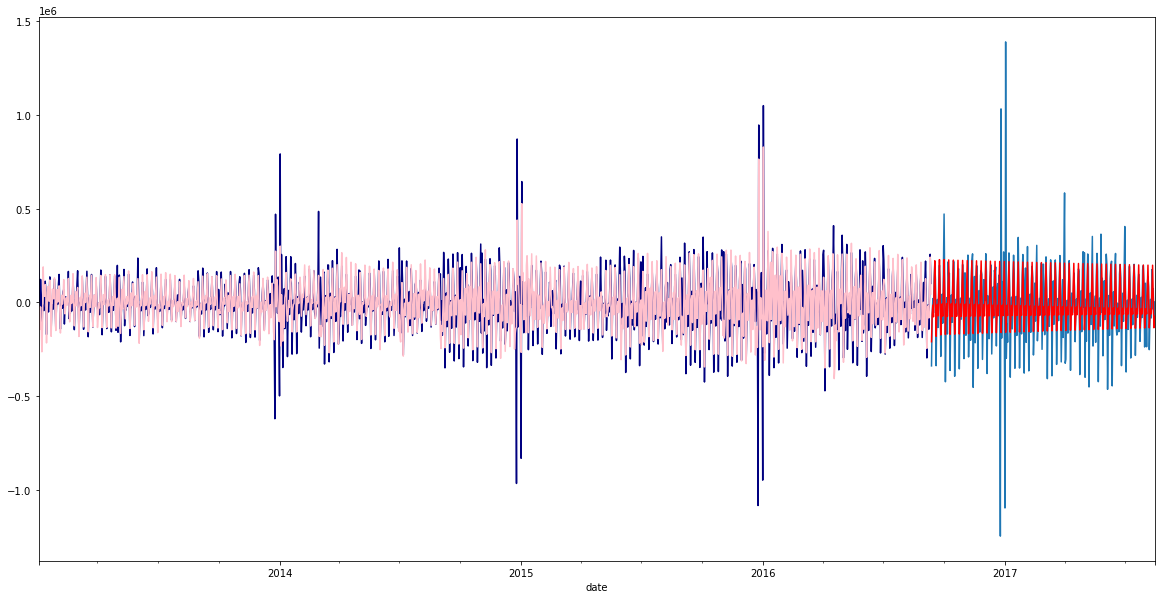

In [ ]:
test['sales_diff'].plot()
train['sales_diff'][1:].plot(color= 'navy')
arma_pred.plot(color = 'red')
arma_train_pred.plot(color = 'pink')

plt.show()

In [ ]:
print('R2 score train is: ', round(r2_score(train['sales_diff'][1:], arma_train_pred),3))
print('R2 score test is: ', round(r2_score(test['sales_diff'], arma_pred),3))

R2 score train is:  0.659
R2 score test is:  0.343


So our first simple model has 0.659 on train set and 0.343 R2 score on test set.  
Let's improve it!

- SARIMA

 a) model decompose (on stationary data)

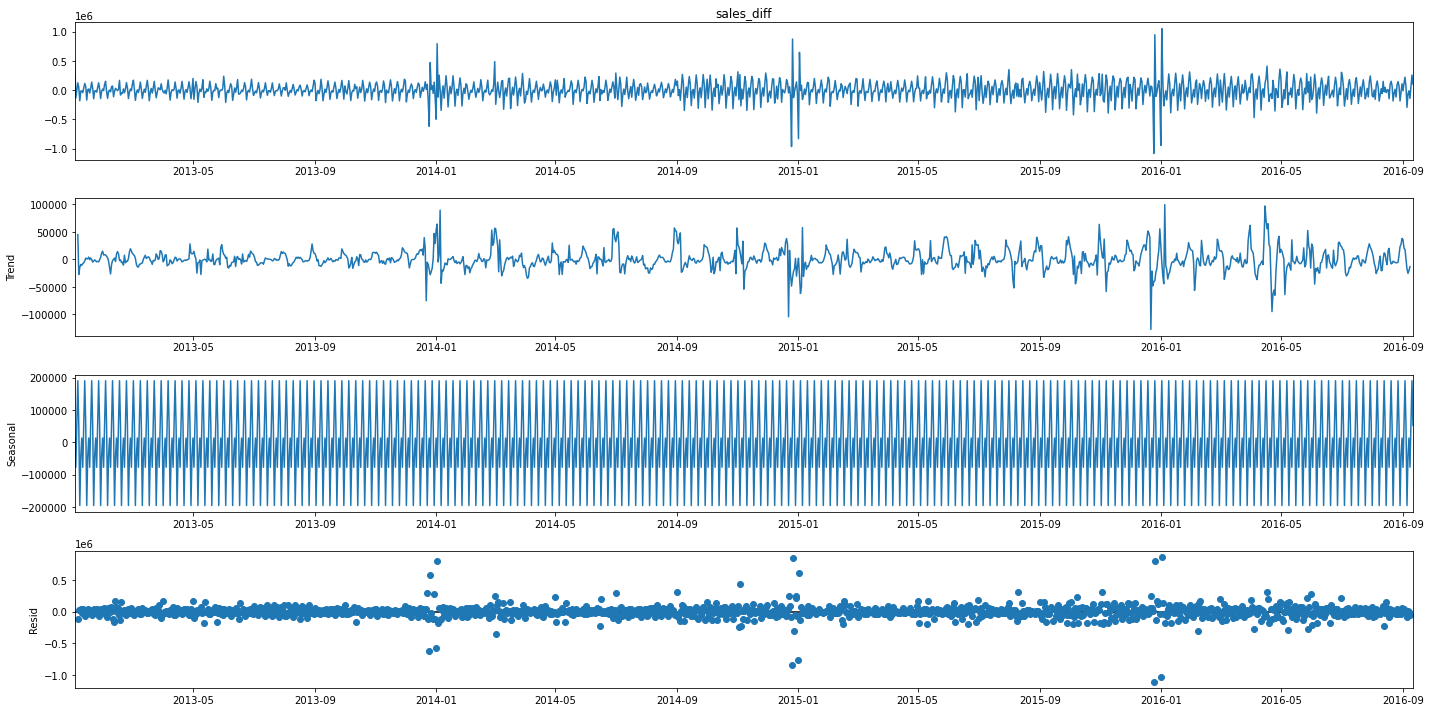

In [ ]:
decomp_stat = seasonal_decompose(train['sales_diff'][1:])
decomp_stat.plot()
plt.show()

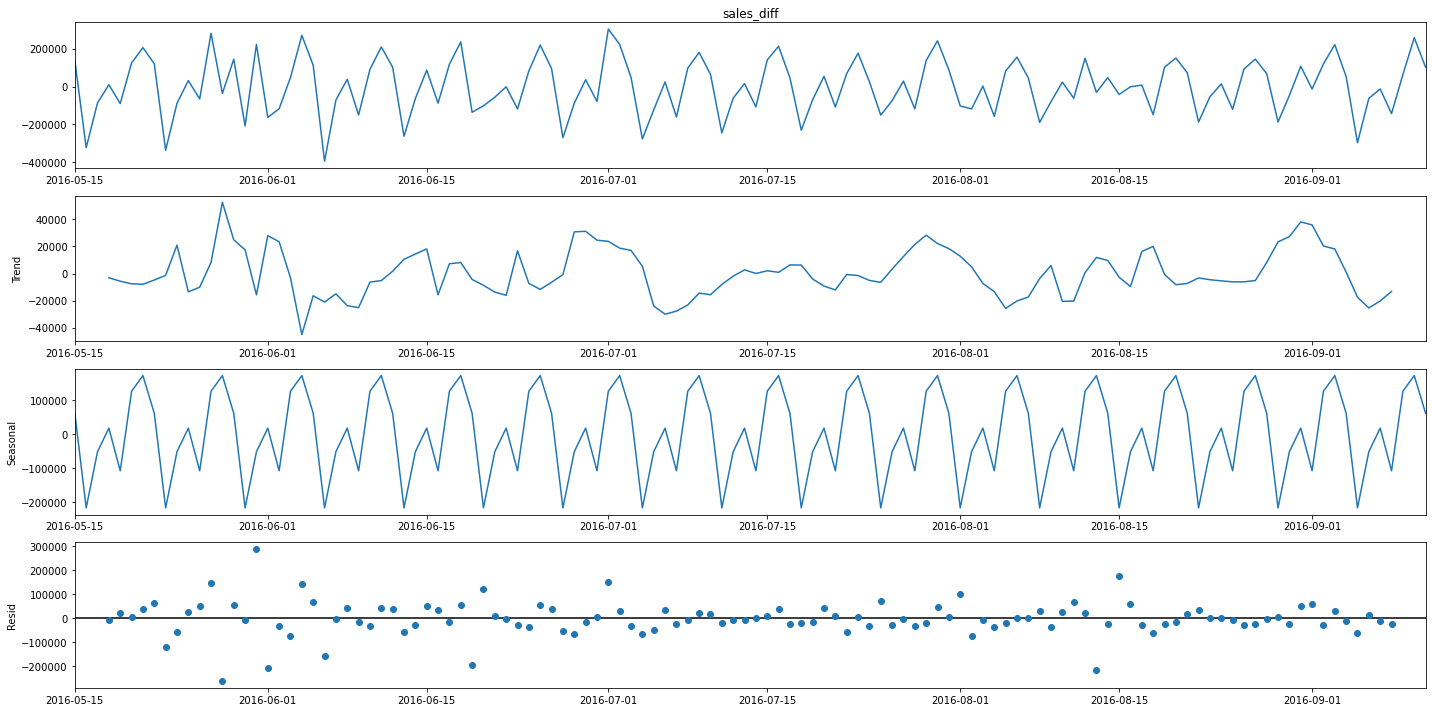

In [ ]:
#let's see trend also for last 4 months
seasonal_decompose(train['sales_diff'][-120:]).plot()
plt.show()

It seems to be weekly seasonal cycle.

b) stationarity test on seasonal data (also stationary)

In [ ]:
# Let's use our decomposed trend and check wheter it is stationary
seasonal_adf = sts.adfuller(decomp_stat.seasonal)
print('p_value = ', seasonal_adf[1])

p_value =  0.9585320860598848


It's looks like our seasonal data isn't stationary, so we should do seasonal differencing

In [ ]:
#Let's make our seasonal data stationary too
train['seasonal_diff'] = train['sales_diff'].diff(7).dropna()

#let's do the same with our test data in case of future use
test2 = pd.concat([train.iloc[-8:,:7],test])
test['seasonal_diff'] = test2['sales_diff'].diff(7).dropna()

In [ ]:
seasonal_diff_adf = sts.adfuller(train['seasonal_diff'].dropna())
print('p_value = ', seasonal_diff_adf[1])

p_value =  2.0441673862320492e-23


Both our main data and seasonal data are now stationary.  
Let choose right model components

c) components choosing 

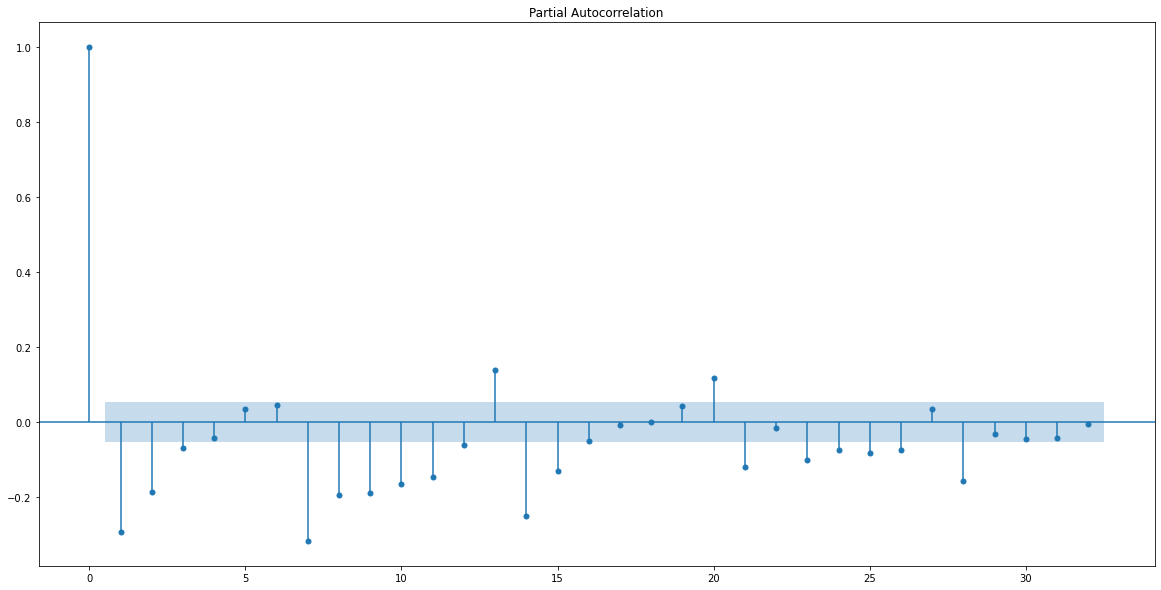

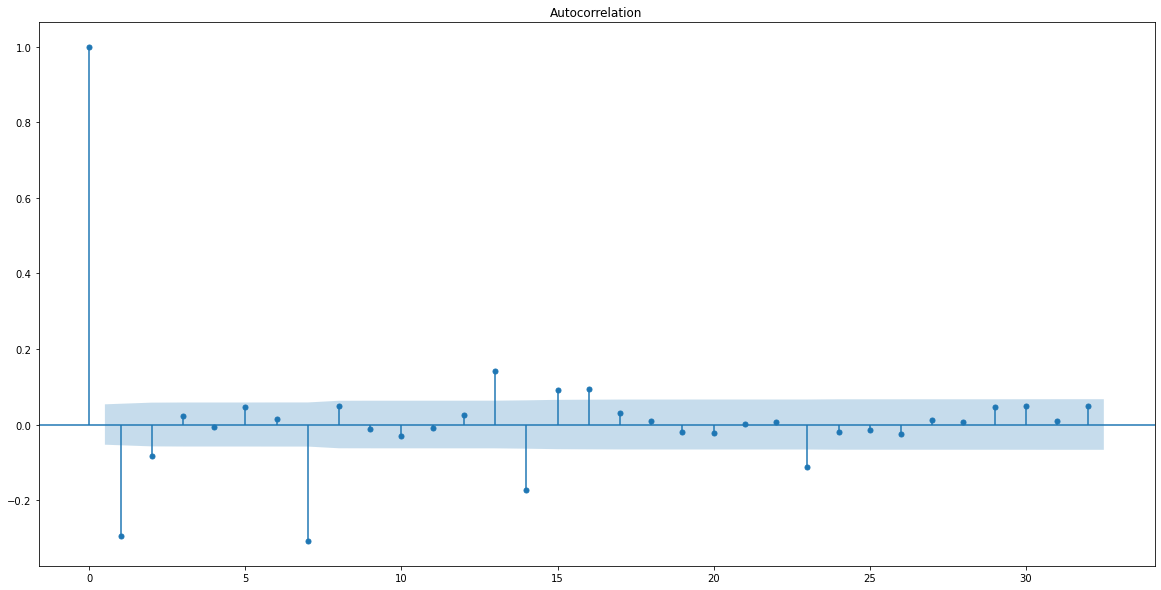

In [ ]:
_ = sgt.plot_pacf(train['seasonal_diff'].dropna())
_ = sgt.plot_acf(train['seasonal_diff'].dropna())
plt.show()

PACF plot sugests that we should consider p not bigger than 3, P min 1, maybe 2, but we check also 3, 4  
ACF plot sugests q not bigger than 2, and Q 1 or 2

d) model definition

In [ ]:
#our parameters grid
p_comp = [1,2,3]
P_comp = [1,2,3,4]
q_comp = [1,2]
Q_comp = [1,2]

In [ ]:
# model definition
def model_sarma(x,p, P, q, Q, d = 7, name = 'name'):
    model = SARIMAX(x, order =(p, 1, q), seasonal_order = (P,1,Q, d))
    result = model.fit()
    return {name: round(result.llf,3)}

In [ ]:
#let check a few diffent models, which will gain the best results, according to the Log Likelihood
loop_results_sarma = dict()

for p in p_comp:
    for P in P_comp:
        for q in q_comp:
            for Q in Q_comp:
                try:
                    x = model_sarma(train['sales'], p, P, q, Q,  name = 'model_sarma_' + str(p) + '_' + str(q) + '_seasonal_' + str(P) + "_" + str(Q))
                    loop_results_sarma.update(x)
                    print('model_sarma_' + str(p) + '_' + str(q) + '_seasonal_' + str(P) + "_"  + str(Q))
                except:
                    continue

model_sarma_1_1_seasonal_1_1
model_sarma_1_1_seasonal_1_2
model_sarma_1_2_seasonal_1_1
model_sarma_1_2_seasonal_1_2
model_sarma_1_1_seasonal_2_1
model_sarma_1_1_seasonal_2_2
model_sarma_1_2_seasonal_2_1
model_sarma_1_2_seasonal_2_2
model_sarma_1_1_seasonal_3_1
model_sarma_1_1_seasonal_3_2
model_sarma_1_2_seasonal_3_1
model_sarma_1_2_seasonal_3_2
model_sarma_1_1_seasonal_4_1
model_sarma_1_1_seasonal_4_2
model_sarma_1_2_seasonal_4_1
model_sarma_1_2_seasonal_4_2
model_sarma_2_1_seasonal_1_1
model_sarma_2_1_seasonal_1_2
model_sarma_2_2_seasonal_1_1
model_sarma_2_2_seasonal_1_2
model_sarma_2_1_seasonal_2_1
model_sarma_2_1_seasonal_2_2
model_sarma_2_2_seasonal_2_1
model_sarma_2_2_seasonal_2_2
model_sarma_2_1_seasonal_3_1
model_sarma_2_1_seasonal_3_2
model_sarma_2_2_seasonal_3_1
model_sarma_2_2_seasonal_3_2
model_sarma_2_1_seasonal_4_1
model_sarma_2_1_seasonal_4_2
model_sarma_2_2_seasonal_4_1
model_sarma_2_2_seasonal_4_2
model_sarma_3_1_seasonal_1_1
model_sarma_3_1_seasonal_1_2
model_sarma_3_

In [ ]:
#Let check 5 best models
best_sarma = pd.DataFrame([loop_results_sarma]).T.rename(columns = {0: 'result'})
best_sarma.sort_values(by = 'result', ascending = False).head(6)

result
model_sarma_3_1_seasonal_4_2 -17270.681
model_sarma_3_2_seasonal_4_2 -17271.121
model_sarma_2_2_seasonal_4_2 -17272.128
model_sarma_2_1_seasonal_4_2 -17272.725
model_sarma_4_2_seasonal_4_2 -17273.047

Our best SARIMA is SARIMA(4,1,1)(4,1,2)7 but as good as SARIMA(3,1,1)(4,1,2)7, so we use less complex model

In [ ]:
model_sarma_3_1_seasonal_4_2 = SARIMAX(train['sales'], order = (3,1,1), seasonal_order=(4,1,2,7))
result_sarma_3_1_seasonal_4_2 = model_sarma_3_1_seasonal_4_2.fit()
result_sarma_3_1_seasonal_4_2.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                  sales   No. Observations:                 1350
Model:             SARIMAX(3, 1, 1)x(4, 1, [1, 2], 7)   Log Likelihood              -17270.681
Date:                                Fri, 15 Apr 2022   AIC                          34563.362
Time:                                        22:15:02   BIC                          34620.583
Sample:                                    01-01-2013   HQIC                         34584.798
                                         - 09-11-2016                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4476      0.028     15.771      0.000       0.392       0.503
ar.L2          0.0834      0.035      2.385      0.017       0.015       0.152
ar.L3          0.0833      0.038      2.190      0.029       0.009       0.158
ma.L1         -0.9657      0.020    -47.807      0.000      -1.005      -0.926
ar.S.L7       -0.7157      0.045    -15.906      0.000      -0.804      -0.627
ar.S.L14       0.2402      0.048      4.977      0.000       0.146       0.335
ar.S.L21      -0.0103      0.077     -0.134      0.893      -0.160       0.140
ar.S.L28      -0.0538      0.064     -0.839      0.401      -0.179       0.072
ma.S.L7        0.0103      0.041      0.253      0.800      -0.069       0.090
ma.S.L14      -0.9334      0.037    -25.030      0.000      -1.006      -0.860
sigma2      1.331e+10   3.16e-12   4.21e+21      0.000    1.33e+10    1.33e+10
===================================================================================
Ljung-Box (Q):                      143.17   Jarque-Bera (JB):             47233.97
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.30   Skew:                            -1.75
Prob(H) (two-sided):                  0.00   Kurtosis:                        31.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.37e+36. Standard errors may be unstable.
"""

Unfortunately not all coefficients are significant.  
Besides that residuals are correlated and haven't normal distribution.  
Let's try simpler model without those coefficients

In [ ]:
model_sarma_3_1_seasonal_1_1 = SARIMAX(train['sales'], order = (3,1,1), seasonal_order=(1,1,1,7))
result_sarma_3_1_seasonal_1_1 = model_sarma_3_1_seasonal_1_1.fit()
result_sarma_3_1_seasonal_1_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             sales   No. Observations:                 1350
Model:             SARIMAX(3, 1, 1)x(1, 1, 1, 7)   Log Likelihood              -17275.896
Date:                           Fri, 15 Apr 2022   AIC                          34565.792
Time:                                   22:24:27   BIC                          34602.206
Sample:                               01-01-2013   HQIC                         34579.433
                                    - 09-11-2016                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4564      0.026     17.547      0.000       0.405       0.507
ar.L2          0.0910      0.033      2.742      0.006       0.026       0.156
ar.L3          0.0764      0.036      2.149      0.032       0.007       0.146
ma.L1         -0.9692      0.018    -54.681      0.000      -1.004      -0.934
ar.S.L7        0.2501      0.022     11.213      0.000       0.206       0.294
ma.S.L7       -0.9617      0.015    -65.466      0.000      -0.990      -0.933
sigma2      1.331e+10   9.76e-13   1.36e+22      0.000    1.33e+10    1.33e+10
===================================================================================
Ljung-Box (Q):                      159.46   Jarque-Bera (JB):             44753.26
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.35   Skew:                            -1.65
Prob(H) (two-sided):                  0.00   Kurtosis:                        31.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.57e+36. Standard errors may be unstable.
"""

This less complex model doesn't have any not significant coefficients, but still residuals are correlated and haven't normal distribution.

e) prediction and evaluation

In [ ]:
sarma_pred = result_sarma_3_1_seasonal_1_1.predict(test.index[0],test.index[-1])
sarma_train_pred = result_sarma_3_1_seasonal_1_1.predict(train.index[0],train.index[-1])

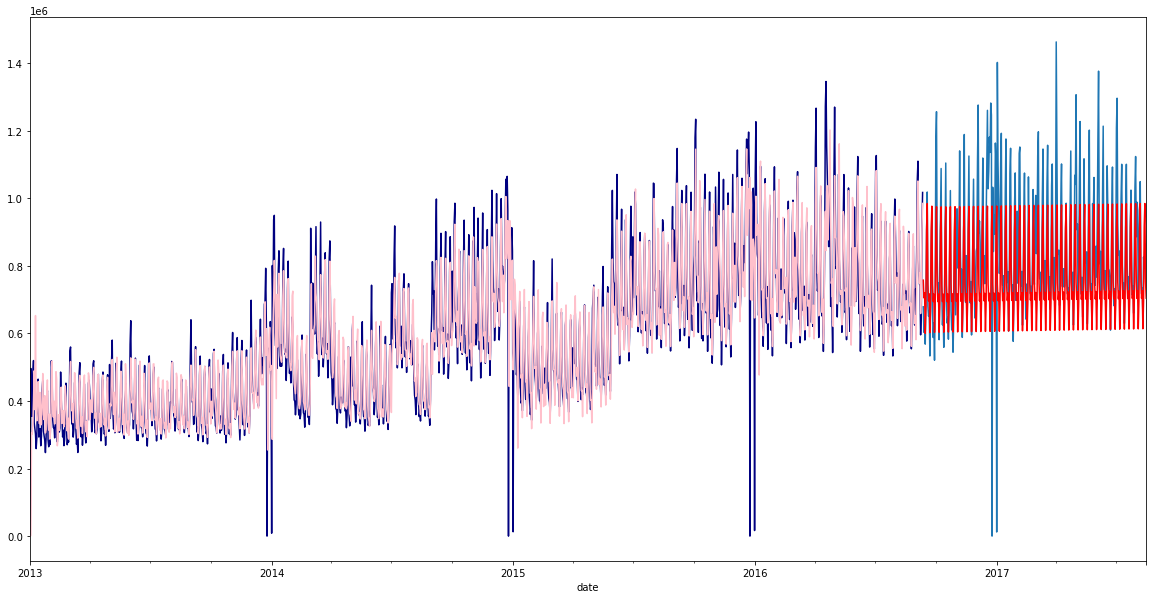

In [ ]:
test['sales'].plot()
train['sales'].plot(color= 'navy')
sarma_pred.plot(color = 'red')
sarma_train_pred.plot(color = 'pink')

plt.show()

In [ ]:
print('R2 score train is: ', round(r2_score(train['sales'], sarma_train_pred),3))
print('R2 score test is: ', round(r2_score(test['sales'], sarma_pred),3))

R2 score train is:  0.828
R2 score test is:  0.263


We have very good results on train set, but still poor on test dataset.

- SARIMAX

In [ ]:
#let's use some exogeous variables with our best SARIMA model.  First wday and holiday type
model_sarimax_3_1_seasonal_1_1 = SARIMAX(train['sales'],exog = train[['wday','type']], order = (3,1,1), seasonal_order=(1,1,1,7))
result_sarimax_3_1_seasonal_1_1 = model_sarimax_3_1_seasonal_1_1.fit()
result_sarimax_3_1_seasonal_1_1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             sales   No. Observations:                 1350
Model:             SARIMAX(3, 1, 1)x(1, 1, 1, 7)   Log Likelihood              -17275.038
Date:                           Sat, 16 Apr 2022   AIC                          34568.076
Time:                                   09:31:47   BIC                          34614.893
Sample:                               01-01-2013   HQIC                         34585.614
                                    - 09-11-2016                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
wday        5.687e-05   9395.973   6.05e-09      1.000   -1.84e+04    1.84e+04
type       -1547.0982   2726.872     -0.567      0.570   -6891.669    3797.472
ar.L1          0.4566      0.027     17.171      0.000       0.404       0.509
ar.L2          0.0923      0.034      2.707      0.007       0.025       0.159
ar.L3          0.0767      0.036      2.149      0.032       0.007       0.147
ma.L1         -0.9692      0.018    -54.600      0.000      -1.004      -0.934
ar.S.L7        0.2489      0.022     11.110      0.000       0.205       0.293
ma.S.L7       -0.9617      0.015    -64.625      0.000      -0.991      -0.933
sigma2       1.33e+10      0.024    5.5e+11      0.000    1.33e+10    1.33e+10
===================================================================================
Ljung-Box (Q):                      156.40   Jarque-Bera (JB):             43678.80
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.36   Skew:                            -1.61
Prob(H) (two-sided):                  0.00   Kurtosis:                        30.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.92e+27. Standard errors may be unstable.
"""

In [ ]:
#let's use some exogeous variables with our best SARIMA model.  Then with oil price and transactions, too.
model_sarimax_3_1_seasonal_1_1 = SARIMAX(train['sales'],exog = train[['wday','type', 'transactions','oil_price']], order = (3,1,1), seasonal_order=(1,1,1,7))
result_sarimax_3_1_seasonal_1_1 = model_sarimax_3_1_seasonal_1_1.fit()
result_sarimax_3_1_seasonal_1_1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             sales   No. Observations:                 1350
Model:             SARIMAX(3, 1, 1)x(1, 1, 1, 7)   Log Likelihood              -16686.562
Date:                           Sat, 16 Apr 2022   AIC                          33395.123
Time:                                   09:35:52   BIC                          33452.345
Sample:                               01-01-2013   HQIC                         33416.559
                                    - 09-11-2016                                         
Covariance Type:                             opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
wday         -5.178e-06   6.66e+04  -7.78e-11      1.000    -1.3e+05     1.3e+05
type          1696.8720   1833.876      0.925      0.355   -1897.459    5291.203
transactions     6.6084      0.086     77.046      0.000       6.440       6.776
oil_price     2196.0042   1664.695      1.319      0.187   -1066.738    5458.746
ar.L1            0.7744      0.031     24.683      0.000       0.713       0.836
ar.L2           -0.1464      0.027     -5.377      0.000      -0.200      -0.093
ar.L3            0.1505      0.044      3.434      0.001       0.065       0.236
ma.L1           -0.9653      0.025    -39.080      0.000      -1.014      -0.917
ar.S.L7          0.0578      0.046      1.265      0.206      -0.032       0.147
ma.S.L7         -0.9223      0.022    -42.138      0.000      -0.965      -0.879
sigma2        5.879e+09      0.141   4.16e+10      0.000    5.88e+09    5.88e+09
===================================================================================
Ljung-Box (Q):                       99.44   Jarque-Bera (JB):             17104.01
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.46   Skew:                             1.63
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.21e+27. Standard errors may be unstable.
"""

How we can see, only transaction is significant coef. but it is also corelated with sale, so we shouldn't use it.  
Let's better try with some feature enginering from oil_price.  Let's lag this variable.

In [ ]:
train['oil_price_shift_1d'] = train['oil_price'].shift(1)
train['oil_price_shift_7d'] = train['oil_price'].shift(7)
train['oil_price_shift_30d'] = train['oil_price'].shift(30)

In [ ]:
model_sarimax_3_1_seasonal_1_1_ex3 = SARIMAX(train['sales'][30:],exog = train[['type','oil_price_shift_1d', 'oil_price_shift_7d','oil_price_shift_30d']][30:], order = (3,1,1), seasonal_order=(1,1,1,7))
result_sarimax_3_1_seasonal_1_1_ex3 = model_sarimax_3_1_seasonal_1_1_ex3.fit()
result_sarimax_3_1_seasonal_1_1_ex3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             sales   No. Observations:                 1320
Model:             SARIMAX(3, 1, 1)x(1, 1, 1, 7)   Log Likelihood              -16893.949
Date:                           Sat, 16 Apr 2022   AIC                          33809.898
Time:                                   09:56:27   BIC                          33866.871
Sample:                               01-31-2013   HQIC                         33831.265
                                    - 09-11-2016                                         
Covariance Type:                             opg                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
type                -1384.7084   2879.160     -0.481      0.631   -7027.758    4258.341
oil_price_shift_1d  -1491.3505   3072.294     -0.485      0.627   -7512.936    4530.235
oil_price_shift_7d   -956.8778   3299.704     -0.290      0.772   -7424.178    5510.423
oil_price_shift_30d  3824.8134   2886.035      1.325      0.185   -1831.711    9481.338
ar.L1                   0.4485      0.027     16.355      0.000       0.395       0.502
ar.L2                   0.0833      0.035      2.375      0.018       0.015       0.152
ar.L3                   0.0823      0.037      2.205      0.027       0.009       0.155
ma.L1                  -0.9723      0.017    -57.819      0.000      -1.005      -0.939
ar.S.L7                 0.2482      0.024     10.475      0.000       0.202       0.295
ma.S.L7                -0.9621      0.016    -60.829      0.000      -0.993      -0.931
sigma2               1.353e+10      0.012   1.11e+12      0.000    1.35e+10    1.35e+10
===================================================================================
Ljung-Box (Q):                      162.03   Jarque-Bera (JB):             41947.61
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.45   Skew:                            -1.60
Prob(H) (two-sided):                  0.00   Kurtosis:                        30.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.11e+26. Standard errors may be unstable.
"""

Not this time too.  
Let's try automate this proces, using auto-arima

- AUTO-ARIMA 

In [58]:
model_auto = auto_arima(
    train['sales'],
    m = 7,
    seasonal = True,
    max_p = 7,
    max_q = 7,
    max_d = 1,
    max_P = 7,
    max_Q = 7,
    max_D = 1,
    maxiter= 50,
    n_jobs = -1,
    trend = 'ct',
    out_of_sample = int(len(train)*0.2),
    error_action = 'ignore',
    stepwise = True,
    trace = True)    

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=34858.787, Time=3.25 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=36077.447, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=35406.263, Time=0.48 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=35605.944, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=36077.447, Time=0.05 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=35210.800, Time=2.44 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=inf, Time=3.96 sec
 ARIMA(2,1,2)(2,0,1)[7] intercept   : AIC=34855.704, Time=6.11 sec
 ARIMA(2,1,2)(2,0,0)[7] intercept   : AIC=inf, Time=6.67 sec
 ARIMA(2,1,2)(3,0,1)[7] intercept   : AIC=34857.417, Time=23.61 sec
 ARIMA(2,1,2)(2,0,2)[7] intercept   : AIC=inf, Time=11.25 sec
 ARIMA(2,1,2)(1,0,2)[7] intercept   : AIC=34852.770, Time=7.74 sec
 ARIMA(2,1,2)(0,0,2)[7] intercept   : AIC=35087.378, Time=4.72 sec
 ARIMA(2,1,2)(1,0,3)[7] intercept   : AIC=34853.723, Time=16.74 sec
 ARIMA(2,1,2)(0,0,3)[7] intercept 

In [24]:
#our best model according to auto_arima
model_auto 

ARIMA(order=(3, 1, 2), scoring_args={}, seasonal_order=(4, 0, 4, 7),
      suppress_warnings=True, trend='ct', with_intercept=False)

In [30]:
# model_auto1 = SARIMAX(train['sales'],order = (3,1,2), seasonal_order=(4, 0, 4, 7), trend='ct').fit()
# auto_pred1 = pd.DataFrame({
#     'index' : test.index,
#     'result': model_auto1.predict(start = test.index[0], end = test.index[-1])
#                           }).set_index('index')

In [31]:
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                          SARIMAX Results                                           
====================================================================================================
Dep. Variable:                                        sales   No. Observations:                 1350
Model:             SARIMAX(3, 1, 2)x(4, 0, [1, 2, 3, 4], 7)   Log Likelihood              -17361.349
Date:                                      Mon, 25 Apr 2022   AIC                          34754.698
Time:                                              18:42:09   BIC                          34838.012
Sample:                                          01-01-2013   HQIC                         34785.901
                                               - 09-11-2016                                         
Covariance Type:                                        opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    878.3721    994.710      0.883      0.377   -1071.223    2827.967
drift         -0.6946      1.254     -0.554      0.580      -3.152       1.763
ar.L1         -0.6989      0.062    -11.355      0.000      -0.820      -0.578
ar.L2          0.2931      0.072      4.050      0.000       0.151       0.435
ar.L3          0.0175      0.037      0.473      0.636      -0.055       0.090
ma.L1          0.1524      0.060      2.521      0.012       0.034       0.271
ma.L2         -0.8253      0.049    -16.937      0.000      -0.921      -0.730
ar.S.L7       -1.0886      0.171     -6.361      0.000      -1.424      -0.753
ar.S.L14       0.7406      0.170      4.354      0.000       0.407       1.074
ar.S.L21       1.1238      0.156      7.187      0.000       0.817       1.430
ar.S.L28       0.2010      0.173      1.165      0.244      -0.137       0.539
ma.S.L7        1.3853      0.169      8.189      0.000       1.054       1.717
ma.S.L14      -0.3270      0.205     -1.594      0.111      -0.729       0.075
ma.S.L21      -1.1908      0.108    -11.062      0.000      -1.402      -0.980
ma.S.L28      -0.4237      0.138     -3.078      0.002      -0.693      -0.154
sigma2      1.316e+10      0.000   8.43e+13      0.000    1.32e+10    1.32e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):             44715.04
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               2.13   Skew:                            -1.75
Prob(H) (two-sided):                  0.00   Kurtosis:                        30.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.63e+29. Standard errors may be unstable.
"""

But we still see some not significant parameters

In [64]:
auto_pred = pd.DataFrame({
    'index' : test.index,
    'result': model_auto.predict(n_periods= len(test[test.index[0]:test.index[-1]]))
                          }).set_index('index')

In [60]:
print('R2 score test is: ', round(r2_score(test['sales'], auto_pred['result']),3))

R2 score test is:  0.392


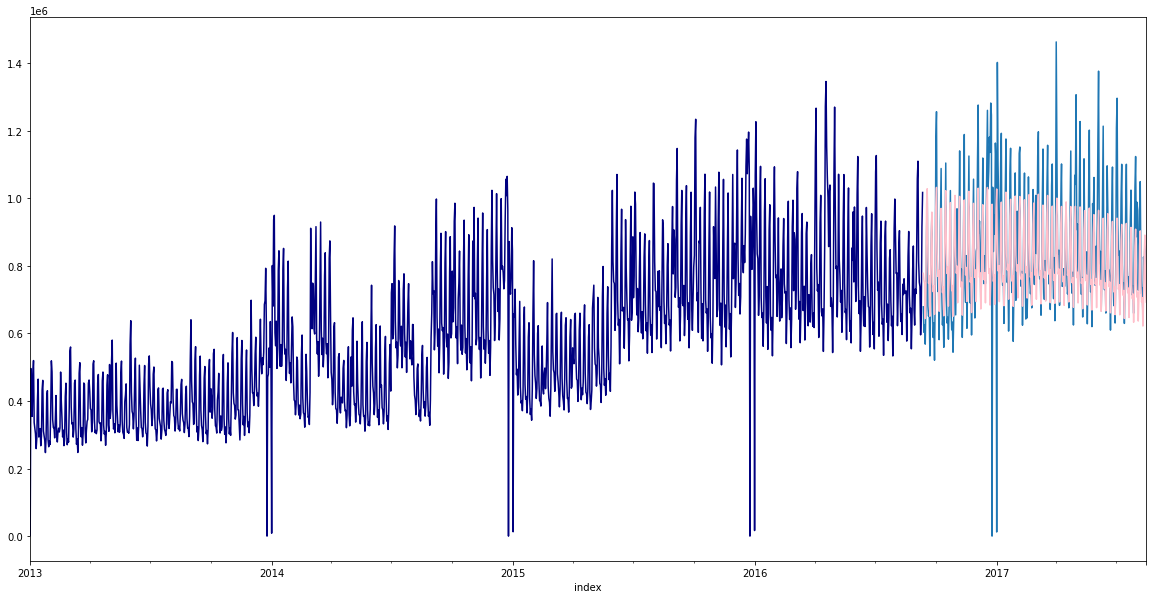

In [61]:
#and plot the results
test['sales'].plot()
train['sales'].plot(color= 'navy')
auto_pred['result'].plot(color = 'pink')

plt.show()

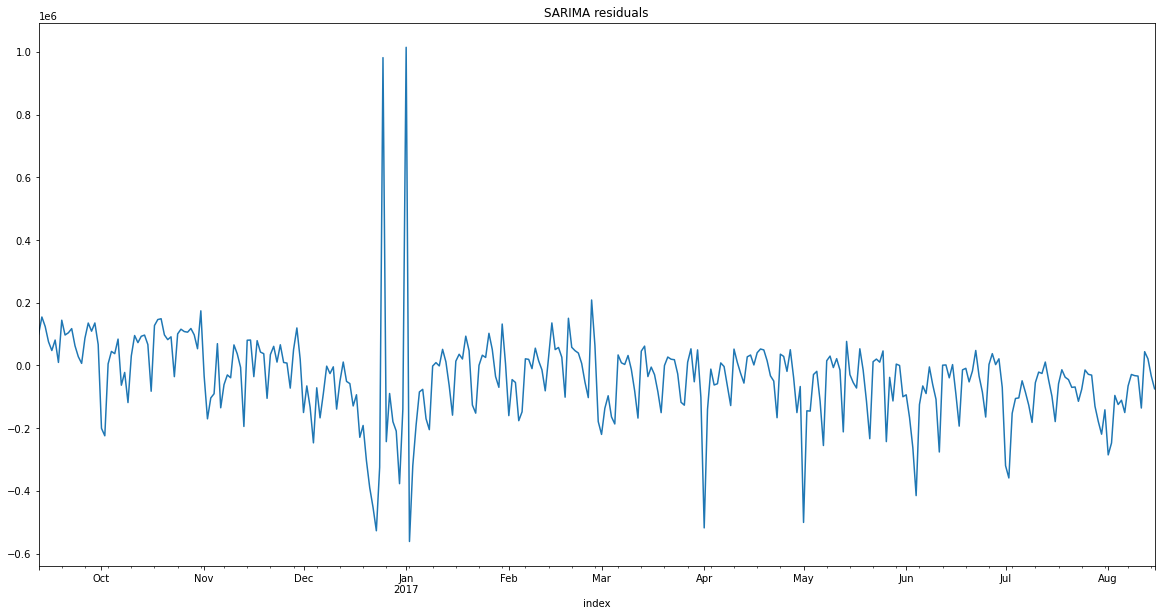

In [ ]:
#let check residuals from our best SARIMA model 
resid_sarima =auto_pred['result']-test['sales']
resid_sarima.plot()
plt.title('SARIMA residuals')
plt.show()

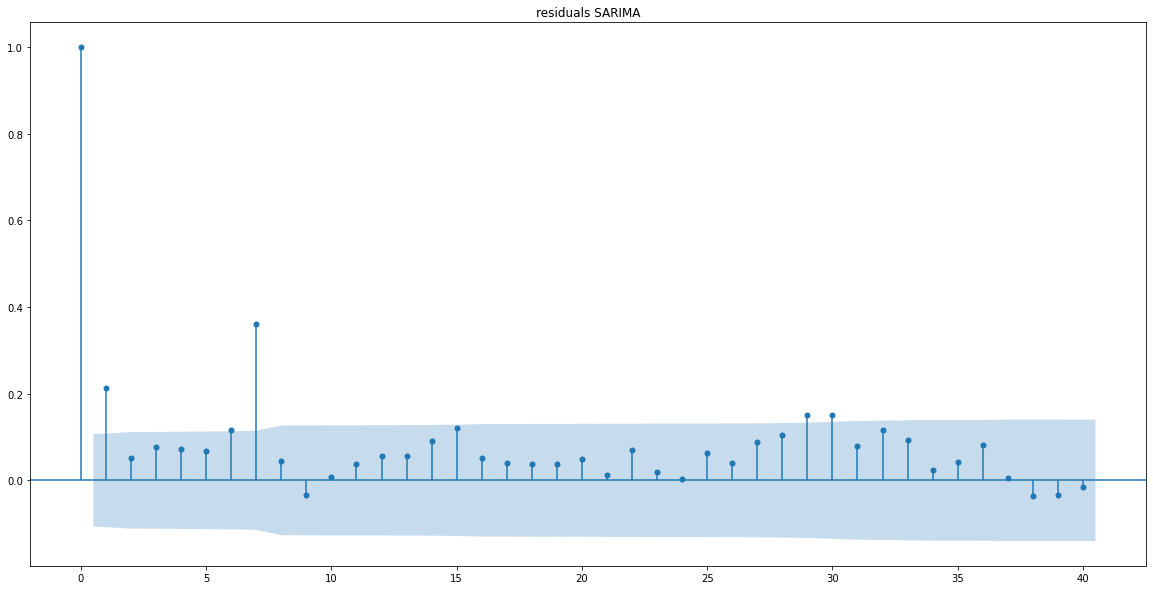

In [ ]:
#let's check if residuals are random noise
sgt.plot_acf(resid_sarima, lags = 40)
plt.title('residuals SARIMA')
plt.show()

Residauls from SARIMA model aren't completely white noise, so there is some space to improve

- Prophet

In [ ]:
#let's try different module prophet with his Prophet model

prophet_model = Prophet(yearly_seasonality= True, weekly_seasonality= True)

In [ ]:
#we have to first prepare our data for the model
train_df = train[['sales']].reset_index()
train_df.rename(columns = {'date': 'ds', 'sales': 'y'}, inplace = True)

test_df = test[['sales']].reset_index()
test_df.rename(columns = {'date': 'ds', 'sales': 'y'}, inplace = True)

train_df

ds             y
0    2013-01-01  2.511619e+03
1    2013-01-02  4.960924e+05
2    2013-01-03  3.614612e+05
3    2013-01-04  3.544597e+05
4    2013-01-05  4.773501e+05
...         ...           ...
1345 2016-09-07  7.385439e+05
1346 2016-09-08  5.958493e+05
1347 2016-09-09  6.589690e+05
1348 2016-09-10  9.159386e+05
1349 2016-09-11  1.017369e+06

[1350 rows x 2 columns]

In [ ]:
prophet_model.fit(train_df)
forecast = prophet_model.predict(test_df)
forecast_train = prophet_model.predict(train_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
print('R2 score train is: ', round(r2_score(train['sales'], forecast_train['yhat']),3))
print('R2 score test is: ', round(r2_score(test['sales'], forecast['yhat']),3))

R2 score train is:  0.747
R2 score test is:  0.428


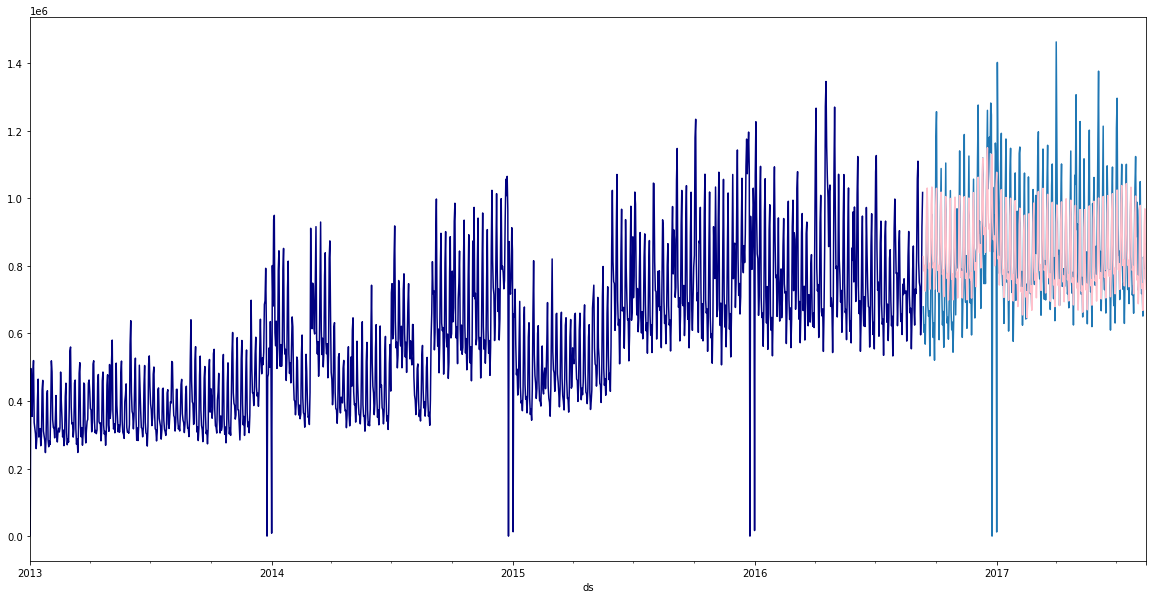

In [ ]:
#and plot the results
forecast_df = forecast[['ds','yhat']].set_index('ds')

test['sales'].plot()
train['sales'].plot(color= 'navy')
forecast_df['yhat'].plot(color = 'pink')
plt.figsize = (20,10)
plt.show()

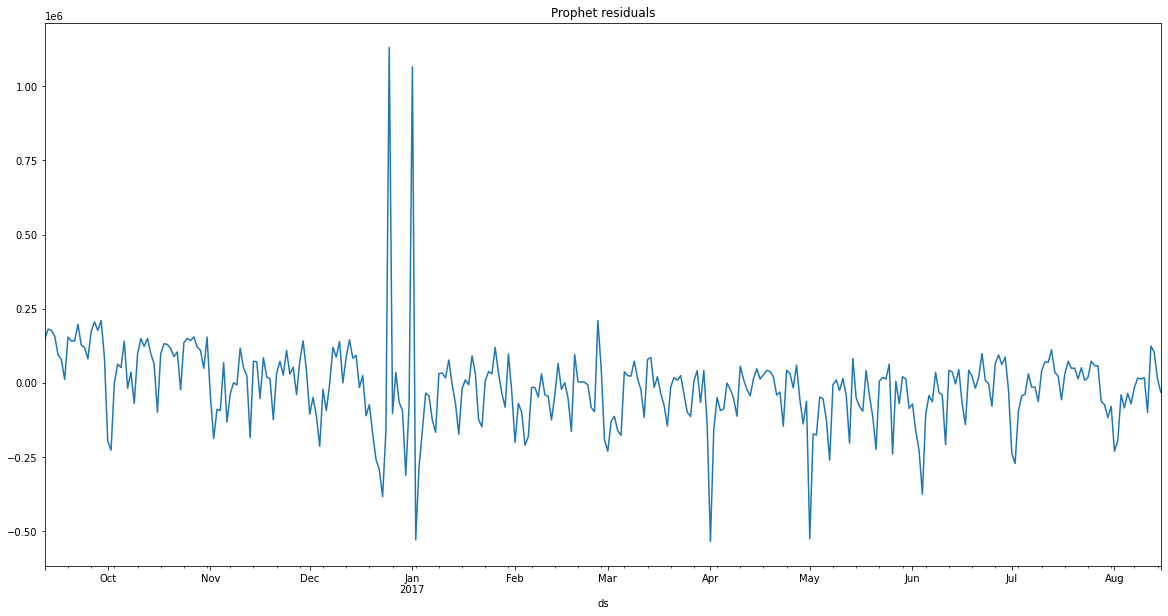

In [ ]:
#let check residuals from our Prophet model 
resid_Prophet =forecast_df['yhat']-test['sales']
resid_Prophet.plot()
plt.title('Prophet residuals')
plt.show()

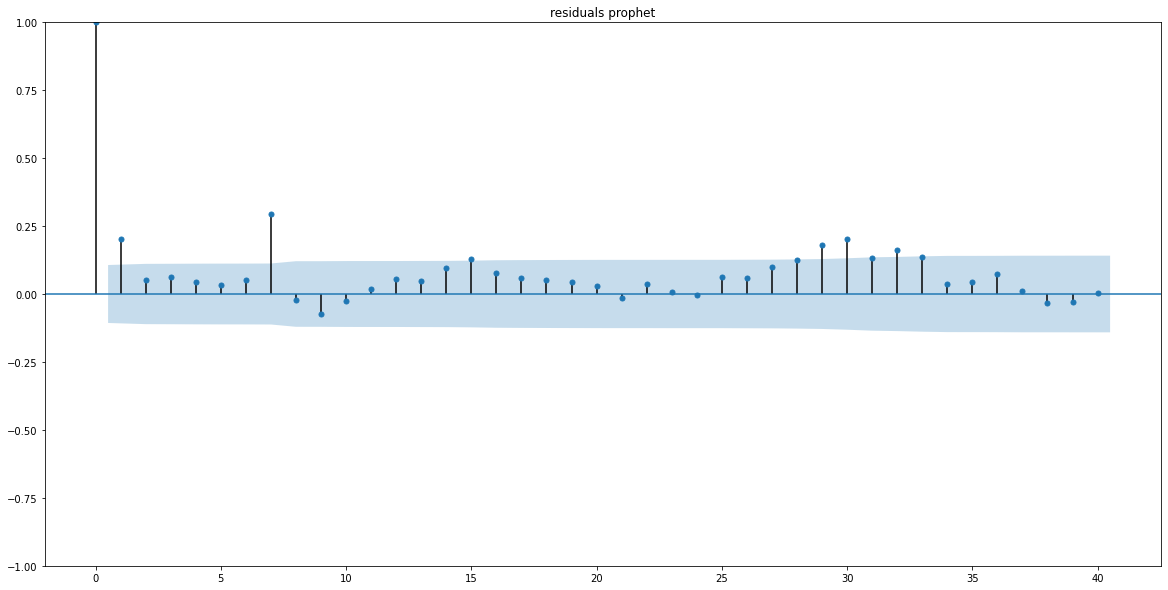

In [ ]:
#let's check if residuals are random noise
sgt.plot_acf(resid_Prophet, lags = 40)
plt.title('residuals prophet')
plt.show()

As we can see Prophet model gives as better result than all ARMA family models, but his residuals aren't white noise.

- LSTM

a) preparation

In [ ]:
#let's try with more sophisticated models, deep learning models.
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
#let's normalize our data to get best results
train_X = np.array(train['sales']).reshape(-1,1)
test_X = np.array(test['sales']).reshape(-1,1)
minmax_scaler = MinMaxScaler().fit(train_X)
X_train_norm = minmax_scaler.transform(train_X)
X_test_norm = minmax_scaler.transform(test_X)

train_norm = train.copy()
test_norm = test.copy()

train_norm['sales'] = X_train_norm
test_norm['sales'] = X_test_norm

In [ ]:
#let's again concate our train and test data to prepare sequential data, and finally split it into train and test
all_df = pd.concat([train_norm.iloc[:,:7], test_norm])

In [ ]:
#first we have to prepare right imput data format, i.e. sequential

def convert_to_seq(x, seq_len, feature_num):
    '''
    x - a numpy array with timeseries data to predict
    seq_len - sequantial lenght, depending on case can be different
    feature_num - number of features to use
    
    '''
    
    total_len = x.shape[0]
    xSeq =[]
    
    for i in range(total_len - seq_len):
        xSeq.append(x[i:i+seq_len])
    
    xSeq = np.array(xSeq).reshape(-1, seq_len, feature_num)
   
    try:
        y = np.array(x.iloc[seq_len:,0]).reshape(-1,1)
    except:
        y = xSeq[seq_len:,0].reshape(-1,1)
    
    return xSeq, y

In [ ]:
xSeq, y = convert_to_seq(all_df['sales'], 30,1)

In [ ]:
# we should also create a function which will update or sequence by adding predicted values to our previous sequence

def uptade_seq(seq,value):
    '''
    seq - sequence which we want to extend,
    value - value which will be add on the end of previous sequence
    
    '''
    
    seqLen = seq.shape[0]
    updadedSeq = np.zeros(seqLen)
    updatedSeq[:seqLen - 1] = seq[1:]
    updatedSeq[-1] = value
    
    return updatedSeq

In [ ]:
xSeq.shape, y.shape

((1658, 30, 1), (1628, 1))

As we can see our xSeq lenght is bigger than y, because of nature of sequence.  
So we won't have targets for our last 7 observations.  
Let's split our data set on train, test, and last 7 observations without targets

In [ ]:
treshold_seq = int(len(y)*0.8)

train_xSeq = xSeq[:treshold_seq]
test_xSeq  = xSeq[treshold_seq:y.shape[0]]
future_xSeq =xSeq[y.shape[0]:]

train_y = y[:treshold_seq]
test_y = y[treshold_seq:]


train_xSeq.shape, test_xSeq.shape, future_xSeq.shape, train_y.shape, test_y.shape


((1302, 30, 1), (326, 30, 1), (30, 30, 1), (1302, 1), (326, 1))

b) basic model

In [ ]:
def model_lstm(x, y, x_test, y_test, units_lstm, seq_len,dropout_out = 0.3, 
               dropout_lstm = 0, layers_num = 1, num_feature = 1, epoch = 100, print_summary = False):
    
    '''
    dropout_lstm - size of dropout between lstm layers
    dropout_out - size of dropout on the last lstm layers
    seq_len - sequence lenght
    units_lstm - number of units for lstm layers
    layers_num - number of lstm layers
    epoch - number of epoch to iterate
    
    '''
    model = tf.keras.Sequential()
    
    
    if layers_num > 1 :
        
        model.add(layers.LSTM(units = units_lstm, input_shape = (seq_len, num_feature),return_sequences = True))
        model.add(layers.Dropout(dropout_lstm))
        
        for n in range(2,layers_num+1):
            if n < layers_num:
                model.add(layers.LSTM(units = units_lstm, return_sequences= True))
                model.add(layers.Dropout(dropout_lstm))
                
            else:
                model.add(layers.LSTM(units = units_lstm))
                model.add(layers.Dropout(dropout_out))
            
    else:
        model.add(layers.LSTM(units = units_lstm, input_shape = (seq_len, num_feature)))
        model.add(layers.Dropout(dropout_out))
        
    
    model.add(layers.Dense(units =1))
    
    if print_summary:
        print(model.summary())
    
    model.compile(
        optimizer='adam',
        loss="mse"
    )
    
    model.fit(x, y, epochs = epoch, batch_size = seq_len, validation_data = (x_test, y_test), 
              callbacks =[EarlyStopping(monitor = 'val_loss', patience = 3)])
    
    return model

In [ ]:
model_lstm1 = model_lstm(train_xSeq, train_y, test_xSeq, test_y, units_lstm= 10, seq_len = 30,
           dropout_lstm = 0.0, dropout_out = 0.3, layers_num = 2, num_feature = 1, epoch = 10)

Epoch 1/10
44/44 [==============================] - 18s 214ms/step - loss: 0.0619 - val_loss: 0.0314
Epoch 2/10
44/44 [==============================] - 8s 176ms/step - loss: 0.0257 - val_loss: 0.0259
Epoch 3/10
44/44 [==============================] - 8s 178ms/step - loss: 0.0235 - val_loss: 0.0235
Epoch 4/10
44/44 [==============================] - 7s 173ms/step - loss: 0.0224 - val_loss: 0.0304
Epoch 5/10
44/44 [==============================] - 7s 171ms/step - loss: 0.0199 - val_loss: 0.0241
Epoch 6/10
44/44 [==============================] - 8s 179ms/step - loss: 0.0201 - val_loss: 0.0258


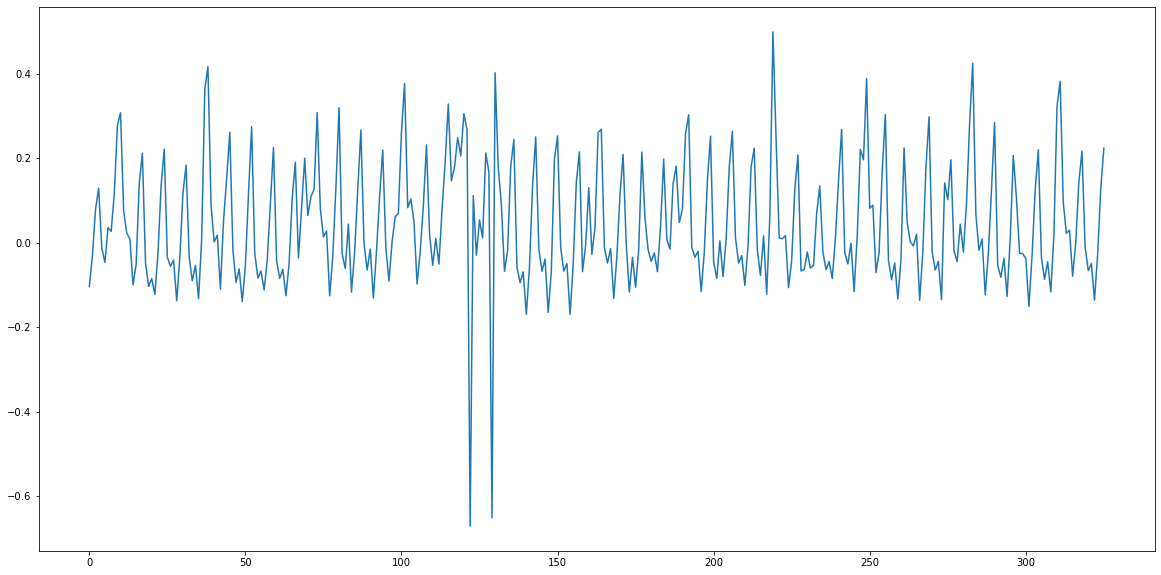

In [ ]:
#let's see how looks residuals plot
y_pred = model_lstm1.predict(test_xSeq)
y_pred_train = model_lstm1.predict(train_xSeq)

y_err = test_y - y_pred
plt.plot(y_err)
plt.show()

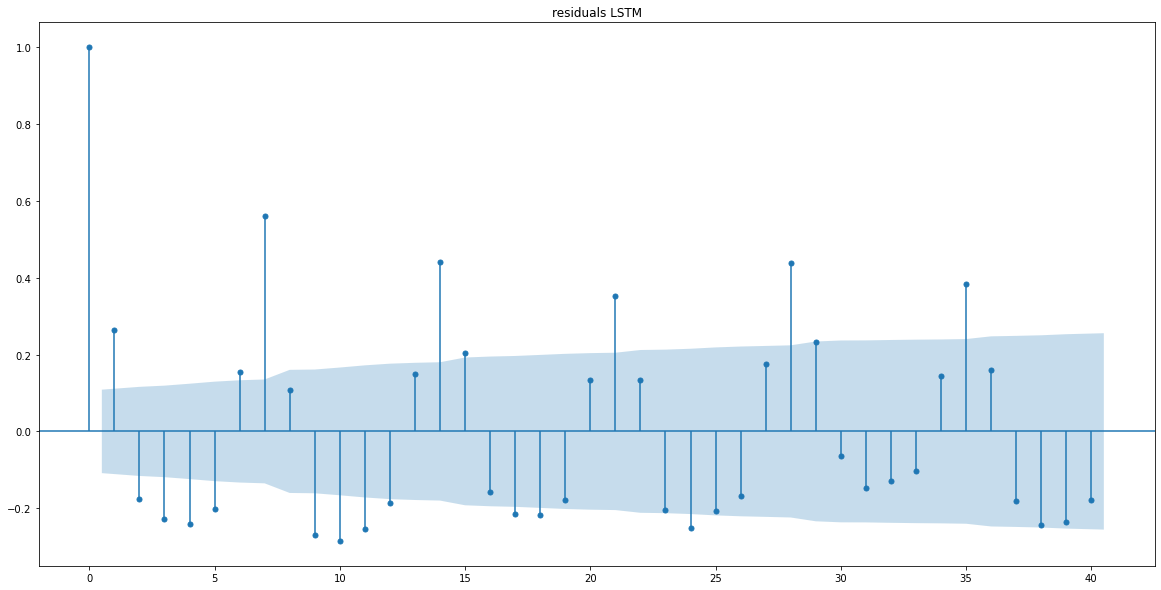

In [ ]:
# and let's check if our residuals are white noise
sgt.plot_acf(y_err, lags = 40)
plt.title('residuals LSTM')
plt.show()

As we can see our residuals aren't really white noise, there are still some patterns whose we should take into account

In [ ]:
print('R2 score train is: ', round(r2_score(train_y, y_pred_train),3))
print('R2 score test is: ', round(r2_score(test_y, y_pred),3))

R2 score train is:  0.514
R2 score test is:  -0.074


Ok our first basic model hasn't return us any interesting results, so let's try use more parameters.

c) model with different range of parameters

In [ ]:
params = {'units_lstm': [4,8,16, 32],
          'layers_num': [2,3,4],
          'dropout_lstm': [0,0.2,0.3, 0.5],
          'dropout_out': [0.2,0.5],
         }

In [ ]:
data = pd.DataFrame({'name' : [],
       'result': []})

for units_lstm in params['units_lstm']:
    for layers_num in params['layers_num']:
        for dropout_lstm in params['dropout_lstm']:
            for dropout_out in params['dropout_out']:
               
                model = model_lstm(train_xSeq, train_y, test_xSeq, test_y, units_lstm= units_lstm, seq_len = 30,
                   dropout_lstm = dropout_lstm, dropout_out = dropout_out, layers_num = layers_num, num_feature = 1, epoch = 50)
                
                
                y_pred = model.predict(test_xSeq)
                y_pred_train = model.predict(train_xSeq)
                
                result = r2_score(test_y, y_pred)
                
                data = data.append({'name' : f' model_units_{units_lstm}_layers_{layers_num}_drop_lstm_{dropout_lstm}_drop_{dropout_out}',
                    'result' : result}, ignore_index = True)
                                   
                data.sort_values('result', ascending = False)

Epoch 1/50
44/44 [==============================] - 16s 201ms/step - loss: 184062.4844 - val_loss: 86911.2812
Epoch 2/50
44/44 [==============================] - 7s 168ms/step - loss: 172234.6719 - val_loss: 47615.5039
Epoch 3/50
44/44 [==============================] - 7s 168ms/step - loss: 243763.5156 - val_loss: 147983.9375
Epoch 4/50
44/44 [==============================] - 7s 168ms/step - loss: 52884.1641 - val_loss: 27262.7969
Epoch 5/50
44/44 [==============================] - 7s 168ms/step - loss: 49695.7734 - val_loss: 98012.8750
Epoch 6/50
44/44 [==============================] - 8s 175ms/step - loss: 118869.2734 - val_loss: 30628.2422
Epoch 7/50
44/44 [==============================] - 7s 170ms/step - loss: 75786.3281 - val_loss: 143452.4375
Epoch 1/50
44/44 [==============================] - 16s 203ms/step - loss: 338170.8750 - val_loss: 374057.5000
Epoch 2/50
44/44 [==============================] - 7s 168ms/step - loss: 499701.7812 - val_loss: 375942.8750
Epoch 3/50
44/44

Epoch 11/50
44/44 [==============================] - 7s 169ms/step - loss: 31125.5645 - val_loss: 86027.2422
Epoch 12/50
44/44 [==============================] - 7s 167ms/step - loss: 13707.4043 - val_loss: 80720.0391
Epoch 13/50
44/44 [==============================] - 7s 173ms/step - loss: 59134.2656 - val_loss: 37946.0898
Epoch 1/50
44/44 [==============================] - 19s 224ms/step - loss: 71311.7422 - val_loss: 37901.1172
Epoch 2/50
44/44 [==============================] - 8s 181ms/step - loss: 44921.7617 - val_loss: 57452.9805
Epoch 3/50
44/44 [==============================] - 8s 179ms/step - loss: 39846.3711 - val_loss: 34759.3203
Epoch 4/50
44/44 [==============================] - 8s 181ms/step - loss: 56334.9414 - val_loss: 63123.9766
Epoch 5/50
44/44 [==============================] - 8s 180ms/step - loss: 52703.6797 - val_loss: 28305.2539
Epoch 6/50
44/44 [==============================] - 8s 180ms/step - loss: 19344.7109 - val_loss: 81170.2891
Epoch 7/50
44/44 [======

44/44 [==============================] - 7s 169ms/step - loss: 245667.9844 - val_loss: 198932.6406
Epoch 4/50
44/44 [==============================] - 7s 167ms/step - loss: 111198.3438 - val_loss: 31942.4785
Epoch 5/50
44/44 [==============================] - 8s 175ms/step - loss: 127706.2578 - val_loss: 12886.9629
Epoch 6/50
44/44 [==============================] - 7s 171ms/step - loss: 184850.7812 - val_loss: 31547.9297
Epoch 7/50
44/44 [==============================] - 7s 168ms/step - loss: 33670.8164 - val_loss: 228897.3750
Epoch 8/50
44/44 [==============================] - 7s 168ms/step - loss: 123576.0000 - val_loss: 43070.2070
Epoch 1/50
44/44 [==============================] - 16s 201ms/step - loss: 177778.9688 - val_loss: 210993.4062
Epoch 2/50
44/44 [==============================] - 7s 167ms/step - loss: 153330.3594 - val_loss: 86277.0000
Epoch 3/50
44/44 [==============================] - 7s 168ms/step - loss: 75218.6875 - val_loss: 30469.5684
Epoch 4/50
44/44 [==========

44/44 [==============================] - 9s 202ms/step - loss: 34861.1758 - val_loss: 6080.6826
Epoch 4/50
44/44 [==============================] - 9s 196ms/step - loss: 31928.5527 - val_loss: 28800.7578
Epoch 5/50
44/44 [==============================] - 9s 198ms/step - loss: 14356.3320 - val_loss: 7254.2446
Epoch 6/50
44/44 [==============================] - 9s 197ms/step - loss: 18037.6543 - val_loss: 23780.9766
Epoch 1/50
44/44 [==============================] - 22s 251ms/step - loss: 467451.8125 - val_loss: 679698.3750
Epoch 2/50
44/44 [==============================] - 9s 197ms/step - loss: 575495.6875 - val_loss: 213643.9219
Epoch 3/50
44/44 [==============================] - 9s 198ms/step - loss: 26740.7676 - val_loss: 185342.3750
Epoch 4/50
44/44 [==============================] - 9s 197ms/step - loss: 102215.4219 - val_loss: 75667.9688
Epoch 5/50
44/44 [==============================] - 9s 201ms/step - loss: 62162.5117 - val_loss: 25480.5332
Epoch 6/50
44/44 [================

44/44 [==============================] - 23s 263ms/step - loss: 132561.4062 - val_loss: 110211.0547
Epoch 2/50
44/44 [==============================] - 9s 200ms/step - loss: 68374.4062 - val_loss: 20725.5820
Epoch 3/50
44/44 [==============================] - 9s 200ms/step - loss: 28536.0039 - val_loss: 26451.1602
Epoch 4/50
44/44 [==============================] - 9s 200ms/step - loss: 46043.5312 - val_loss: 64138.6445
Epoch 5/50
44/44 [==============================] - 9s 201ms/step - loss: 52482.6914 - val_loss: 156149.5312
Epoch 1/50
44/44 [==============================] - 22s 258ms/step - loss: 157226.0469 - val_loss: 49385.9414
Epoch 2/50
44/44 [==============================] - 9s 200ms/step - loss: 59133.1250 - val_loss: 72096.1641
Epoch 3/50
44/44 [==============================] - 9s 199ms/step - loss: 75381.2500 - val_loss: 109881.1406
Epoch 4/50
44/44 [==============================] - 9s 202ms/step - loss: 59185.8633 - val_loss: 19259.9609 ETA: 0s - loss: 235
Epoch 5/50
4

Epoch 6/50
44/44 [==============================] - 8s 184ms/step - loss: 212610.4375 - val_loss: 233827.9219
Epoch 7/50
44/44 [==============================] - 8s 186ms/step - loss: 53621.4141 - val_loss: 125603.9844: 0s - loss: 66467.74 - ETA: 0s - loss: 62880
Epoch 8/50
44/44 [==============================] - 8s 185ms/step - loss: 88404.7656 - val_loss: 24146.8184
Epoch 9/50
44/44 [==============================] - 8s 186ms/step - loss: 34598.8828 - val_loss: 135519.4219
Epoch 10/50
44/44 [==============================] - 9s 211ms/step - loss: 44563.9062 - val_loss: 26926.9824
Epoch 11/50
44/44 [==============================] - 9s 198ms/step - loss: 36339.2227 - val_loss: 223834.4531
Epoch 1/50
44/44 [==============================] - 20s 232ms/step - loss: 340133.3438 - val_loss: 153840.8281
Epoch 2/50
44/44 [==============================] - 8s 186ms/step - loss: 188667.2031 - val_loss: 255048.4375
Epoch 3/50
44/44 [==============================] - 8s 189ms/step - loss: 11039

In [ ]:
data.sort_values('result', ascending = False)

name     result
58   model_units_16_layers_3_drop_lstm_0.2_drop_0.2 -11.238625
89     model_units_32_layers_4_drop_lstm_0_drop_0.5 -15.272078
35    model_units_8_layers_3_drop_lstm_0.2_drop_0.5 -15.725560
57     model_units_16_layers_3_drop_lstm_0_drop_0.5 -16.343152
3     model_units_4_layers_2_drop_lstm_0.2_drop_0.5 -16.452256
..                                              ...        ...
28    model_units_8_layers_2_drop_lstm_0.3_drop_0.2 -22.416809
47    model_units_8_layers_4_drop_lstm_0.5_drop_0.5 -22.743599
75   model_units_32_layers_2_drop_lstm_0.2_drop_0.5 -22.969105
84   model_units_32_layers_3_drop_lstm_0.3_drop_0.2 -23.373468
73     model_units_32_layers_2_drop_lstm_0_drop_0.5 -24.066322

[96 rows x 2 columns]

In [ ]:
#let's check our best lstm model with one feature
model_lstm2 = model_lstm(train_xSeq, train_y, test_xSeq, test_y, units_lstm= 16, seq_len = 30,
           dropout_lstm = 0.2, dropout_out = 0.2, layers_num = 3, num_feature = 1, epoch = 50, print_summary = True)

y_pred2 = model_lstm2.predict(test_xSeq)
y_pred_train2 = model_lstm2.predict(train_xSeq)

Model: "sequential_262"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_595 (LSTM)              (None, 30, 16)            1152      
_________________________________________________________________
dropout_454 (Dropout)        (None, 30, 16)            0         
_________________________________________________________________
lstm_596 (LSTM)              (None, 30, 16)            2112      
_________________________________________________________________
dropout_455 (Dropout)        (None, 30, 16)            0         
_________________________________________________________________
lstm_597 (LSTM)              (None, 16)                2112      
_________________________________________________________________
dropout_456 (Dropout)        (None, 16)                0         
_________________________________________________________________
dense_200 (Dense)            (None, 1)              

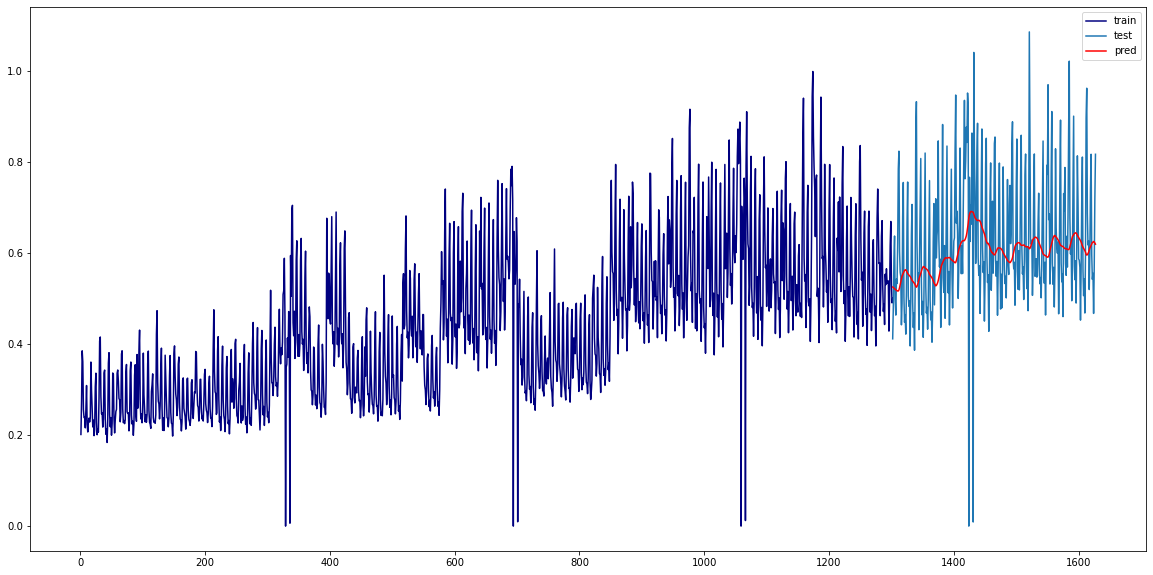

In [ ]:
plt.plot(range(1,train_y.shape[0]+1),train_y, label = 'train', color = 'navy')
plt.plot(range(train_y.shape[0],(train_y.shape[0] + y_pred.shape[0])),test_y, label = 'test')
plt.plot(range(train_y.shape[0],(train_y.shape[0] + y_pred.shape[0])),y_pred2, label = 'pred', color = 'red')
plt.legend()
plt.show()

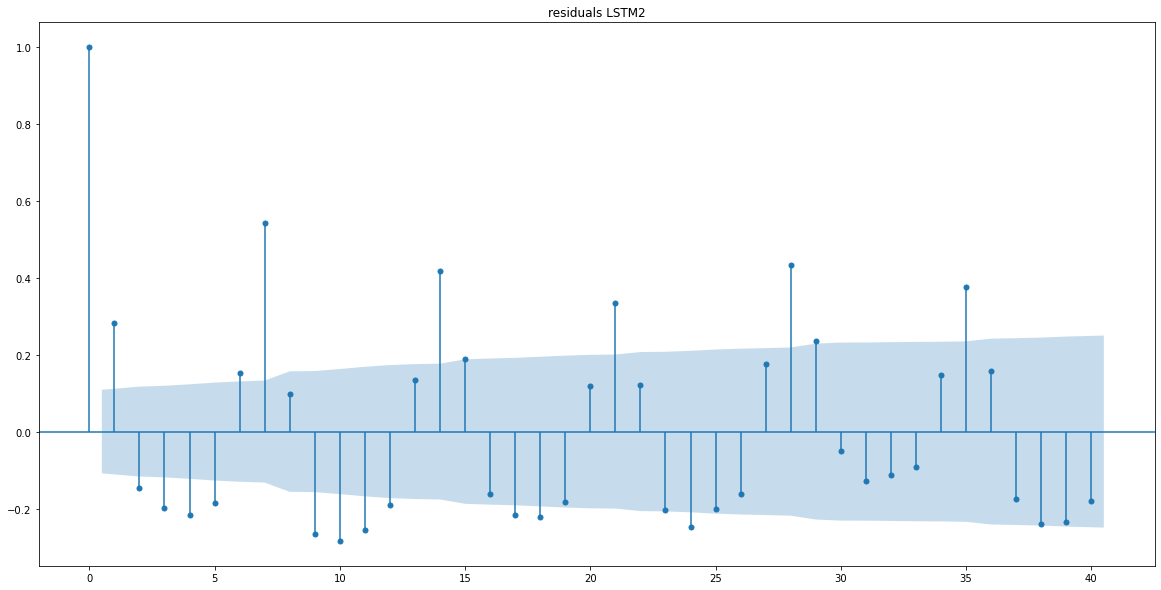

In [ ]:
# and let's check if our residuals are white noise
y_err2 = test_y - y_pred2

sgt.plot_acf(y_err2, lags = 40)
plt.title('residuals LSTM2')
plt.show()

In [ ]:
print('R2 score train is: ', round(r2_score(train_y, y_pred_train2),3))
print('R2 score test is: ', round(r2_score(test_y, y_pred2),3))

R2 score train is:  0.512
R2 score test is:  -0.019


Our prediction get not recommended r2_score results, but on the plot we can see than trend looks really good. 
The problem is that our daily data has too much volatility, maybe we should try to predict weekly data.  
But first let's check if extra features or biderectional lstm layer improve our results

d) model with more features

In [ ]:
xSeq, y = convert_to_seq(all_df[['sales','type','wday']], 30,3)

treshold_seq = int(len(y)*0.8)

train_xSeq = xSeq[:treshold_seq]
test_xSeq  = xSeq[treshold_seq:y.shape[0]]
future_xSeq =xSeq[y.shape[0]:]

train_y = y[:treshold_seq]
test_y = y[treshold_seq:]


train_xSeq.shape, test_xSeq.shape, future_xSeq.shape, train_y.shape, test_y.shape

((1326, 30, 3), (332, 30, 3), (0, 30, 3), (1326, 1), (332, 1))

In [ ]:
#let's check our best lstm model with three feature
model_lstm3 = model_lstm(train_xSeq, train_y, test_xSeq, test_y, units_lstm= 16, seq_len = 30,
           dropout_lstm = 0.2, dropout_out = 0.2, layers_num = 3, num_feature = 3, epoch = 50, print_summary=True)

y_pred3 = model_lstm3.predict(test_xSeq)
y_pred_train3 = model_lstm3.predict(train_xSeq)

Model: "sequential_268"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_612 (LSTM)              (None, 30, 16)            1280      
_________________________________________________________________
dropout_471 (Dropout)        (None, 30, 16)            0         
_________________________________________________________________
lstm_613 (LSTM)              (None, 30, 16)            2112      
_________________________________________________________________
dropout_472 (Dropout)        (None, 30, 16)            0         
_________________________________________________________________
lstm_614 (LSTM)              (None, 16)                2112      
_________________________________________________________________
dropout_473 (Dropout)        (None, 16)                0         
_________________________________________________________________
dense_206 (Dense)            (None, 1)              

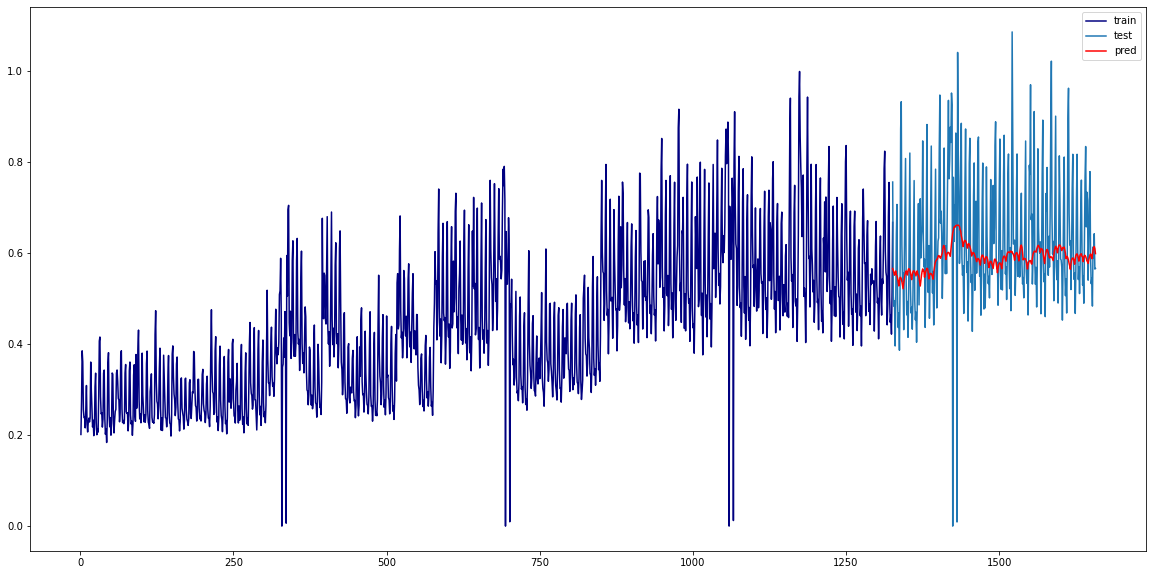

In [ ]:
plt.plot(range(1,train_y.shape[0]+1),train_y, label = 'train', color = 'navy')
plt.plot(range(train_y.shape[0],(train_y.shape[0] + y_pred3.shape[0])),test_y, label = 'test')
plt.plot(range(train_y.shape[0],(train_y.shape[0] + y_pred3.shape[0])),y_pred3, label = 'pred', color = 'red')
plt.legend()
plt.show()

In [ ]:
print('R2 score train is: ', round(r2_score(train_y, y_pred_train3),3))
print('R2 score test is: ', round(r2_score(test_y, y_pred3),3))

R2 score train is:  0.509
R2 score test is:  -0.038


There is no significant improvment with extra features

In [ ]:
#let's creat biderectional lstm model
def model_lstm_2(x, y, x_test, y_test, units_lstm, seq_len,dropout_out = 0.3, 
               dropout_lstm = 0, layers_num = 1, num_feature = 1, epoch = 100, print_summary = False):
    
    '''
    dropout_lstm - size of dropout between lstm layers
    dropout_out - size of dropout on the last lstm layers
    seq_len - sequence lenght
    units_lstm - number of units for lstm layers
    layers_num - number of lstm layers
    epoch - number of epoch to iterate
    
    '''
    model = tf.keras.Sequential()
    
    
    if layers_num > 1 :
        
        model.add(layers.Bidirectional(layers.LSTM(units = units_lstm, input_shape = (seq_len, num_feature),return_sequences = True)))
        model.add(layers.Dropout(dropout_lstm))
        
        for n in range(2,layers_num+1):
            if n < layers_num:
                model.add(layers.Bidirectional(layers.LSTM(units = units_lstm, return_sequences= True)))
                model.add(layers.Dropout(dropout_lstm))
                
            else:
                model.add(layers.Bidirectional(layers.LSTM(units = units_lstm)))
                model.add(layers.Dropout(dropout_out))
            
    else:
        model.add(layers.Bidirectional(layers.LSTM(units = units_lstm, input_shape = (seq_len, num_feature))))
        model.add(layers.Dropout(dropout_out))
        
    
    model.add(layers.Dense(units =1))
    
    
    model.compile(
        optimizer='adam',
        loss="mse"
    )
    
    model.fit(x, y, epochs = epoch, batch_size = seq_len, validation_data = (x_test, y_test), 
              callbacks =[EarlyStopping(monitor = 'val_loss', patience = 3)])
    
    if print_summary:
        print(model.summary())
    
    return model

In [ ]:
xSeq, y = convert_to_seq(all_df['sales'], 30,1)

treshold_seq = int(len(y)*0.8)

train_xSeq = xSeq[:treshold_seq]
test_xSeq  = xSeq[treshold_seq:y.shape[0]]
future_xSeq =xSeq[y.shape[0]:]

train_y = y[:treshold_seq]
test_y = y[treshold_seq:]

e) bidirectional LSTM model

In [ ]:
#let's check our best model with lstm biderectional layers and with one feature
model_lstm_bi = model_lstm_2(train_xSeq, train_y, test_xSeq, test_y, units_lstm= 16, seq_len = 30,
           dropout_lstm = 0.2, dropout_out = 0.2, layers_num = 3, num_feature = 1, epoch = 50, print_summary=True)

y_pred_bi = model_lstm_bi.predict(test_xSeq)
y_pred_train_bi = model_lstm_bi.predict(train_xSeq)

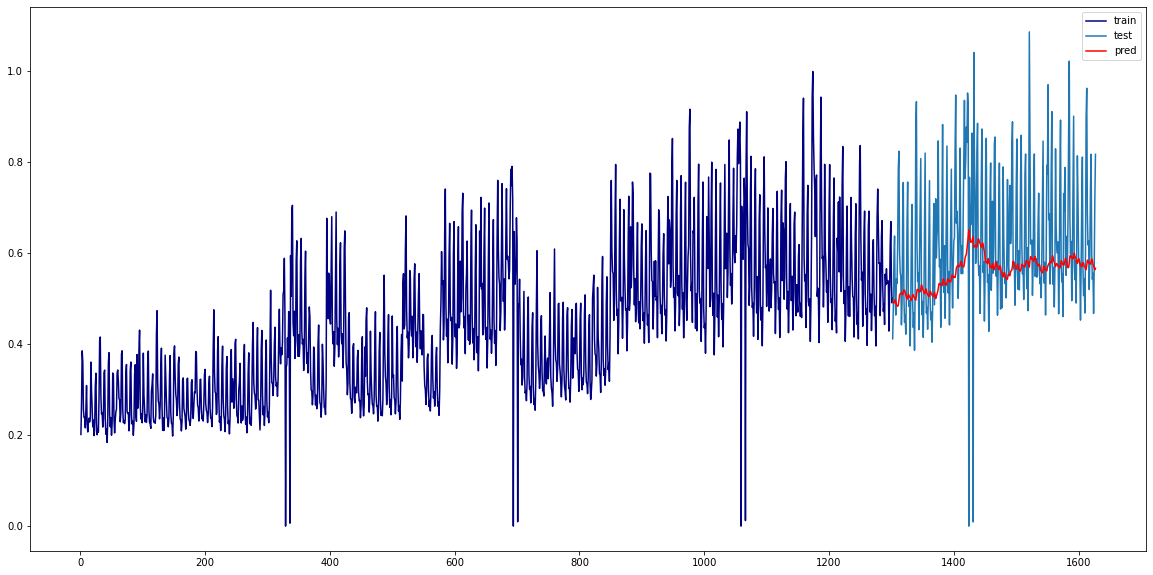

In [ ]:
plt.plot(range(1,train_y.shape[0]+1),train_y, label = 'train', color = 'navy')
plt.plot(range(train_y.shape[0],(train_y.shape[0] + y_pred_bi.shape[0])),test_y, label = 'test')
plt.plot(range(train_y.shape[0],(train_y.shape[0] + y_pred_bi.shape[0])),y_pred_bi, label = 'pred', color = 'red')
plt.legend()
plt.show()

In [ ]:
print('R2 score train is: ', round(r2_score(train_y, y_pred_train_bi),3))
print('R2 score test is: ', round(r2_score(test_y, y_pred_bi),3))

R2 score train is:  0.468
R2 score test is:  -0.18


In this case bidirectional layers give us worst results.

* RGBregressor

a) data preparation

In [ ]:
#our target variable will be our sales, and our explonatory variable will be: last day sale, last week sale, last 30 days sale.
#we also again use holidays info and week days

df_xgb = dataset.copy()
df_xgb['sales_1d_ago'] = df_xgb['sales'].shift(1)
df_xgb['sales_7d_ago'] = df_xgb['sales'].shift(7)
df_xgb['sales_30_ago'] = df_xgb['sales'].shift(30)

#delete all first 30 observation without all required data
df_xgb.dropna(inplace =True)

In [ ]:
# let's again split data set into test and train
#with treshold = 0.8

x_xgb = df_xgb.copy()
del x_xgb['oil_price'],  x_xgb['transactions'],x_xgb['sales']

x_train_xgb = x_xgb.iloc[:treshold,:]
x_test_xgb  = x_xgb.iloc[treshold:,:]

y_train_xgb = df_xgb['sales'].iloc[:treshold]
y_test_xgb = df_xgb['sales'].iloc[treshold:]

print('train size lenght is: ', len(x_train_xgb), '\n'
     'test_size lenght is: ', len(x_test_xgb))

train size lenght is:  1350 
test_size lenght is:  308


b) simple model definition

In [ ]:
#model definition
model_xgb = xgb.XGBRegressor(
    n_estimators = 50,
    max_depth = 5,
    objective= 'reg:squarederror',
    booster = 'gbtree',
    learning_rate = 0.1,
    n_jobs = -1,
    eval_metric = 'mae')

#cross validation definition
tscv = TimeSeriesSplit(n_splits = 5)

In [ ]:
model_xgb.fit(x_train_xgb,y_train_xgb)
cv_result = cross_val_score(model_xgb, x_train_xgb, y_train_xgb, cv = tscv, scoring = 'r2')

In [ ]:
#let's predict future values
y_pred_xgb = model_xgb.predict(x_test_xgb)
print('train r2_score is', round(cv_result.mean(),3))
print('test r2_score is', round(r2_score(y_test_xgb, y_pred_xgb),3))

train r2_score is 0.557
test r2_score is 0.443


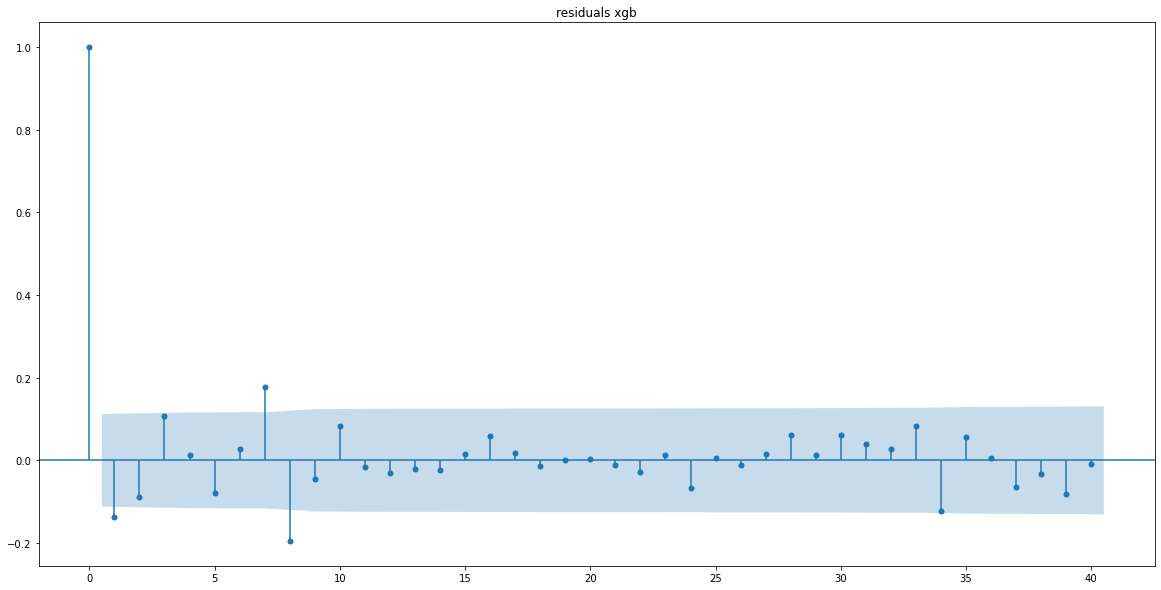

In [ ]:
# check or residuals
resid_xgb = y_pred_xgb - y_test_xgb

sgt.plot_acf(resid_xgb, lags = 40)
plt.title('residuals xgb')
plt.show()

We have some autocorrelation in our residuals, it seems that we can improve our model.

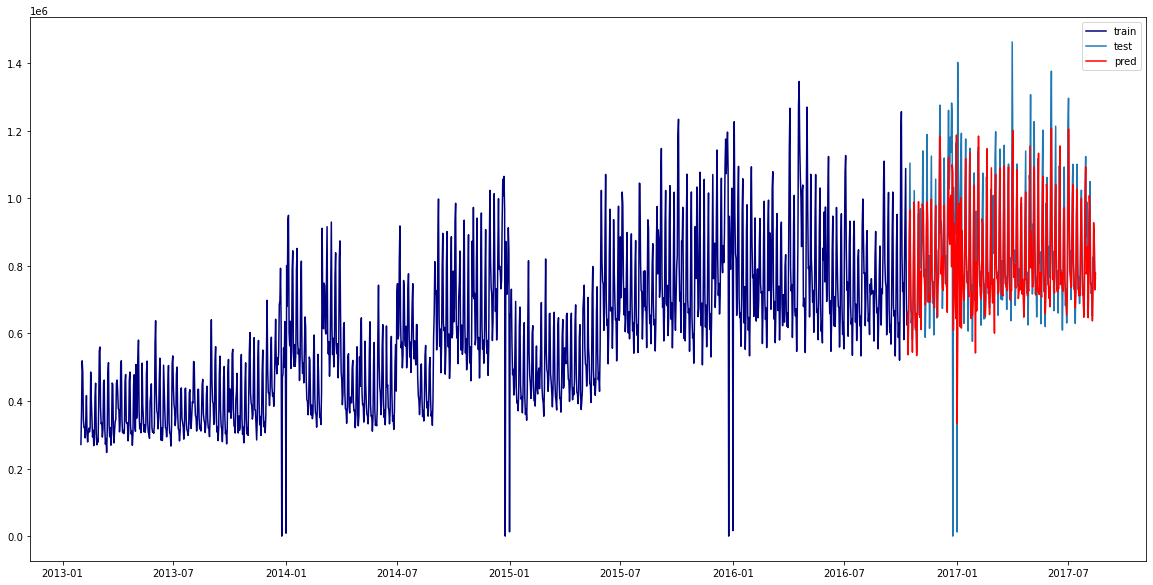

In [ ]:
plt.plot(x_train_xgb.index, y_train_xgb, label = 'train', color = 'navy')
plt.plot(x_test_xgb.index, y_test_xgb, label = 'test')
plt.plot( x_test_xgb.index,y_pred_xgb, label = 'pred', color = 'red')
plt.legend()
plt.show()

As we can see our model performs very very good, but let's try improve it a little bit using hyperopt

In [ ]:
#hyperopt params
param_hyperopt = {
    "learning_rate" : hp.loguniform("learning_rate", np.log(0.01), np.log(1)),
    "max_depth" : scope.int(hp.quniform("max_depth", 4,15,1)),
    "booster" : hp.choice("booster", ['gbtree']),  #'gblinear'
    "reg_lambda": hp.uniform("reg_lambda", 0.0, 0.5),
    "min_child_weight" : scope.int(hp.quniform("min_child_weight", 2,6,1))
}

In [ ]:
# model definition

def model_xgb_hyp(X_train, Y_train, CV, num_eval):
    
    def objective(params):
        
        model = xgb.XGBRegressor(**params, n_estimators = 50, objective= 'reg:squarederror', n_jobs = -1,eval_metric = 'mae')
        
        for a, b in CV.split(X_train):
            eval_set = [(X_train[a], Y_train[a]),(X_train[b], Y_train[b])]
            
            model.fit(X_train[a],Y_train[a], eval_set = eval_set, eval_metric = 'mae', early_stopping_rounds = 5, verbose = False)
            y_pred = model.predict(X_train[b])
            
            score = mean_absolute_error(Y_train[b], y_pred)
            
            return {'loss' : score, 'status': STATUS_OK}
        
        
    params = param_hyperopt 
        
    trials = Trials()
        
    best_params = fmin(objective,
                        space = params,
                        algo = tpe.suggest,
                        max_evals = num_eval,
                        trials = trials)
        
    hyperparams = space_eval(params, best_params)
        
    print('the best params: ', hyperparams)
        
    return hyperparams

In [ ]:
best_params_xgb = model_xgb_hyp(x_train_xgb.values, y_train_xgb.values, CV = tscv, num_eval = 10000)

100%|██| 10000/10000 [2:41:29<00:00,  1.03trial/s, best loss: 70764.1110634084]
the best params:  {'booster': 'gbtree', 'learning_rate': 0.8091368744275707, 'max_depth': 8, 'min_child_weight': 4, 'reg_lambda': 0.3327418131270661}


In [ ]:
best_model_xgb = xgb.XGBRegressor(**best_params_xgb, objective= 'reg:squarederror')
best_model_xgb.fit(x_train_xgb, y_train_xgb)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.8091368744275707, max_delta_step=0, max_depth=8,
             min_child_weight=4, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=0.3327418131270661, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [ ]:
y_pred_best_xgb = best_model_xgb.predict(x_test_xgb)
print('test r2_score is', round(r2_score(y_test_xgb, y_pred_best_xgb),3))

test r2_score is 0.316


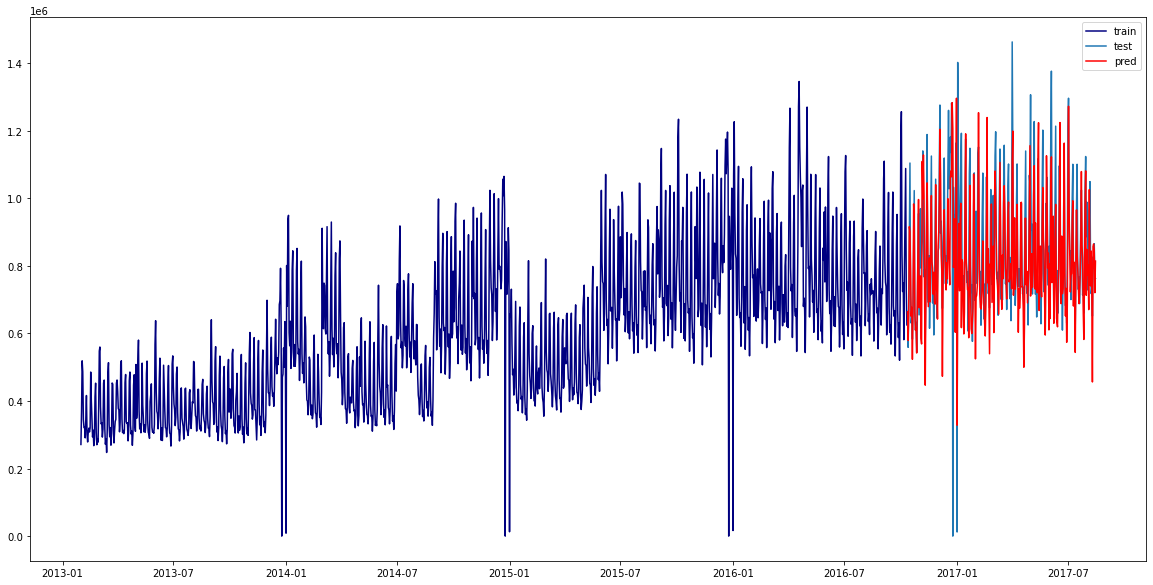

In [ ]:
plt.plot(x_train_xgb.index, y_train_xgb, label = 'train', color = 'navy')
plt.plot(x_test_xgb.index, y_test_xgb, label = 'test')
plt.plot( x_test_xgb.index,y_pred_best_xgb, label = 'pred', color = 'red')
plt.legend()
plt.show()

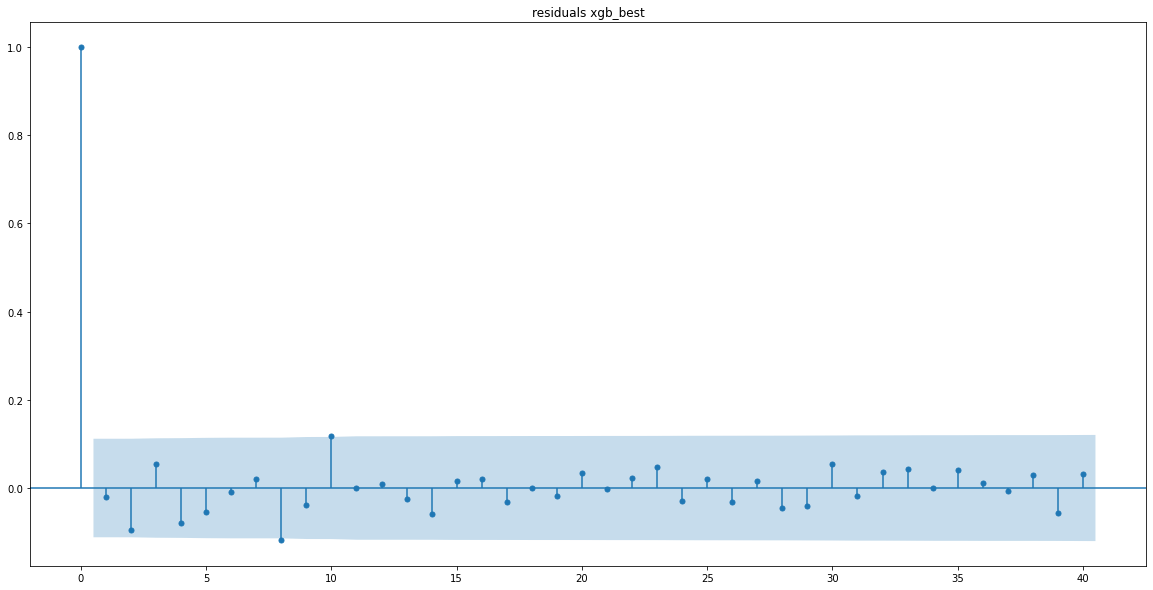

In [ ]:
# check or residuals
resid_best_xgb = y_pred_best_xgb - y_test_xgb

sgt.plot_acf(resid_best_xgb, lags = 40)
plt.title('residuals xgb_best')
plt.show()

As we can see more complex model hasn't improve our r2 score, but his residuals seems to be white noise, beside that we should call model_xgb as our best model, unfortunately we can predict only one day ahead. 

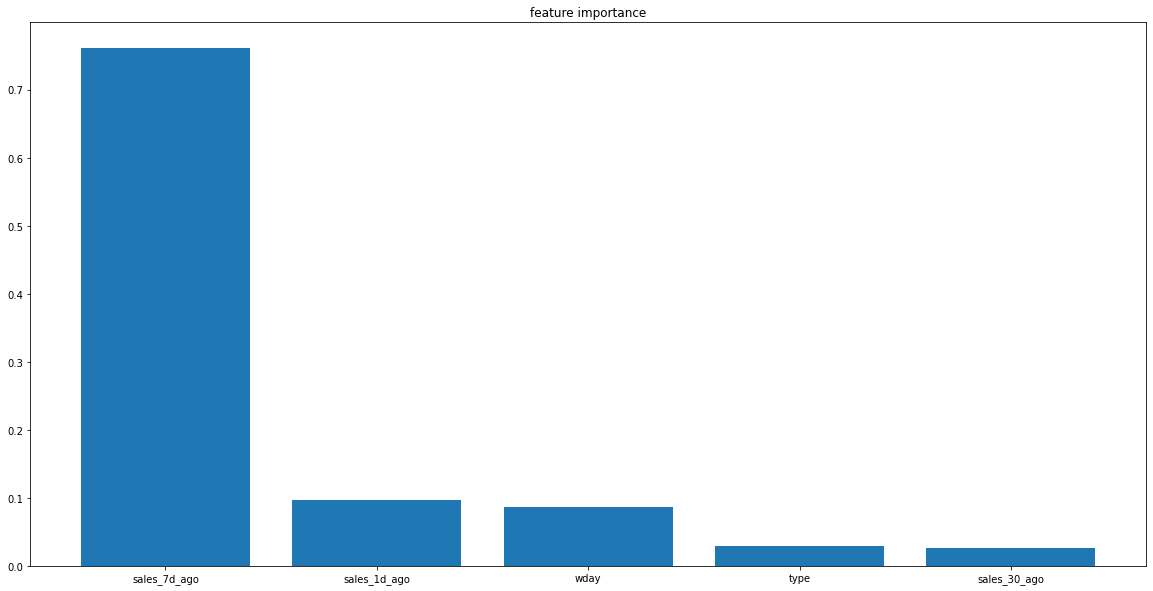

In [ ]:
#let's check which feature seems to be more important to predict
fi  = model_xgb.feature_importances_
fi_df = pd.DataFrame(x_train_xgb.columns, fi).reset_index().sort_values(by = 'index', ascending= False)
plt.bar( fi_df[0],fi_df['index'])
plt.title('feature importance')
plt.show()

Now we see, that the most important feature to predict our model is last week sale, we can assume that holidays type or sales_30_ago is useless. So let's try last attempt, to predict without those feature.

In [ ]:
#model definition
model_xgb_slim = xgb.XGBRegressor(
    n_estimators = 50,
    max_depth = 5,
    objective= 'reg:squarederror',
    booster = 'gbtree',
    learning_rate = 0.1,
    n_jobs = -1,
    eval_metric = 'mae')

model_xgb_slim.fit(x_train_xgb[['wday','sales_1d_ago','sales_7d_ago']],y_train_xgb)
cv_result_slim = cross_val_score(model_xgb_slim, x_train_xgb[['wday','sales_1d_ago','sales_7d_ago']], y_train_xgb, cv = tscv, scoring = 'r2')

#let's predict future values
y_pred_xgb_slim= model_xgb_slim.predict(x_test_xgb[['wday','sales_1d_ago','sales_7d_ago']])
print('train r2_score is', round(cv_result_slim.mean(),3))
print('test r2_score is', round(r2_score(y_test_xgb, y_pred_xgb_slim),3))

train r2_score is 0.554
test r2_score is 0.337


Result is worst than before, so let's stay with full model and try to predict unseen data for test period, using updated sequenced data instead od test set.

In [ ]:
# funtion definition which return y_pred for choosen period based on self, prior predictions
def updated_seq(y, model, seq_dates, seq_len):
    
    '''
    y - timeseries for past periods
    model - XGBmodel which will be use to predict
    seq_dates - data frame which contain date as an index and 'type' column with type of holidys.
            Notice seq_dates, should be long or equal to seq_len
    
    
    seq_len - number of periods to predict ahead.
            Notice seq_len can't be longer than seq_dates
    
    '''
    
    y_updated =pd.DataFrame(y.copy())
    y_pred_1by1 = []
    
    for i in range(seq_len):
        x_test_1by1 = pd.DataFrame({'type': seq_dates['type'][i],
                                    'wday': seq_dates.index[i].weekday()+1,
                                    'sales_1d_ago': y_updated['sales'][-1],
                                    'sales_7d_ago': y_updated['sales'][-7],
                                    'sales_30_ago': y_updated['sales'][-30]
                                    },
                                    index = [seq_dates.index[i]])
    
        y_pred = model.predict(x_test_1by1)
        
        new_row = pd.DataFrame({'sales' :y_pred}, index = [x_test_1by1.index[0]])
        y_pred_1by1 = np.concatenate([y_pred_1by1,y_pred])
    
        y_updated = pd.concat([y_updated,new_row])
        
        
    return y_pred_1by1

In [ ]:
#let's forecast data day by day
y_pred_xgb_1by1 = updated_seq(y_train_xgb, model_xgb, seq_dates = x_test_xgb[['type']], seq_len = len(x_test_xgb))

In [ ]:
print('test r2_score is', round(r2_score(y_test_xgb, y_pred_xgb_1by1),3))

test r2_score is -0.009


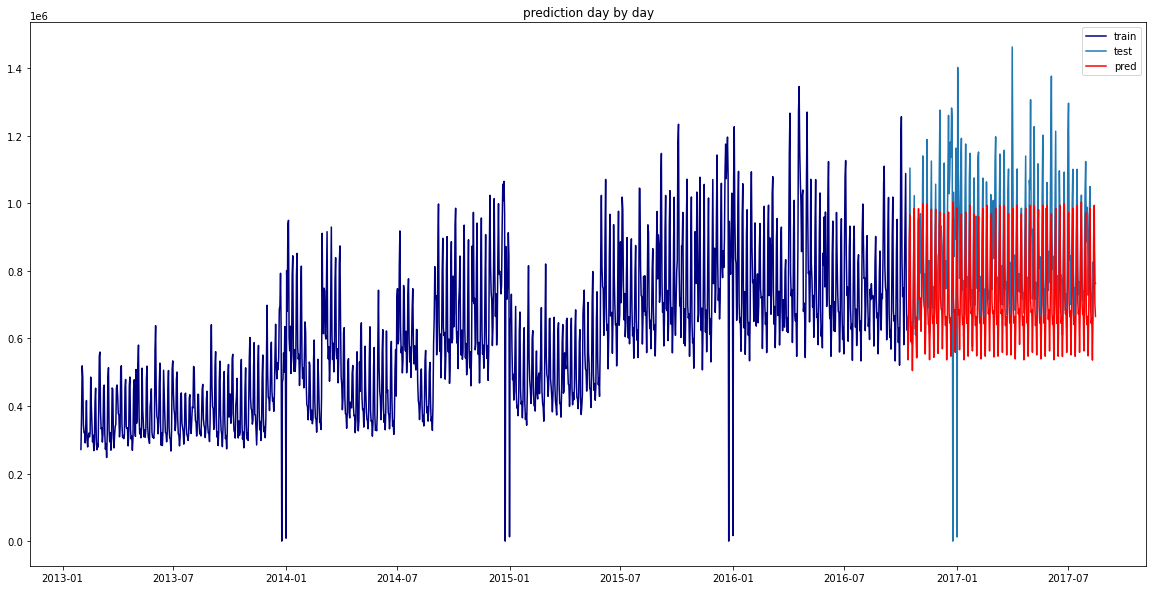

In [ ]:
plt.plot(x_train_xgb.index, y_train_xgb, label = 'train', color = 'navy')
plt.plot(x_test_xgb.index, y_test_xgb, label = 'test')
plt.plot( x_test_xgb.index,y_pred_xgb_1by1, label = 'pred', color = 'red')
plt.legend()
plt.title('prediction day by day')
plt.show()

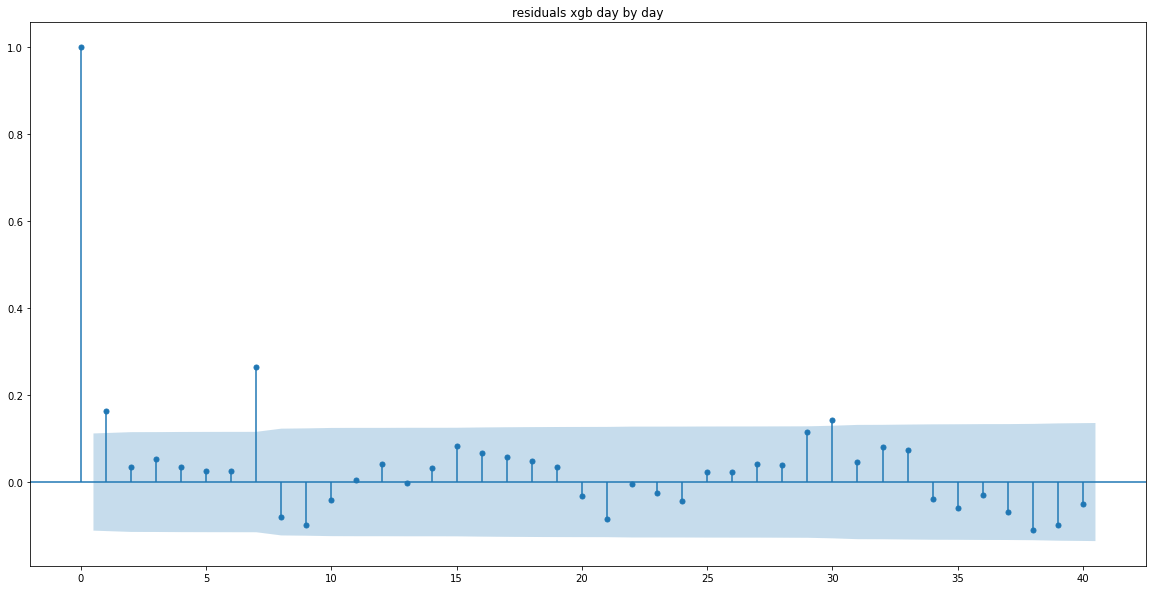

In [ ]:
# check or residuals
resid_xgb_1by1 = y_pred_xgb_1by1 - y_test_xgb

sgt.plot_acf(resid_xgb_1by1, lags = 40)
plt.title('residuals xgb day by day')
plt.show()

As we can see our model, when have to predict more than a few days ahead, using unsean data doesn't improve results obtained by previous models.  
Let's now try to forecast on grouped, weekly data.

In [ ]:
## teraz scalmy dane

In [ ]:
#porob lagi do danych pozniej do proby innego modelu,
# mozna sprobowac osobno zaprognozowac oil prices by moc na tym oprzec prognoze 



Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this.
A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.